# Detection of Seismic Events using Deep Learning (LSTM)

The challenge we faced was to filter seismic data from Mars and the Moon, identifying and transmitting only the relevant impact data. The task was critical, as seismic data from these extraterrestrial sources is vast, and manually sifting through it for valuable information is inefficient and time-consuming.

To tackle this, our team turned to deep learning, specifically leveraging Long Short-Term Memory (LSTM) models, which are excellent for sequence prediction. We framed the problem within a time-window approach, allowing us to detect whether a particular timestamp in the seismic data signaled a relevant event, like an impact, or if it could be discarded.

At the inference stage, we refined our approach by filtering out "lonely" detections—those with fewer than two seismic events in a 100-second window. After this, we grouped the remaining detections into clusters and pinpointed the start and end times of each cluster, effectively marking the regions with multiple, closely spaced seismic events. We then plotted these clusters and outputted the start and end timestamps, ensuring a clear representation of where relevant seismic activity occurred.

In the end, our solution not only filtered the data for relevant impacts but also provided clear visual and numerical outputs to facilitate further analysis.

## Dowload the dataset
This utilizes colab magic cells. if this doesn't work, update the cell to run these bash commands in your environment.

In [1]:
%%bash
# We rehosted the data on our servers for faster download times in colab notebooks (Challenge links were caped at 2MB). This link will probably no work after sometime.
wget https://tmp2.server.ahmedsaed.me/space_apps_2024_seismic_detection.zip
unzip space_apps_2024_seismic_detection.zip
# All files follow a uniform format expect for one file which we believe was a mistake so we renamed it to follow the same format
mv ./space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR02_evid00029.csv ./space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR00_evid00029.csv

Archive:  space_apps_2024_seismic_detection.zip
   creating: space_apps_2024_seismic_detection/
   creating: space_apps_2024_seismic_detection/.ipynb_checkpoints/
  inflating: space_apps_2024_seismic_detection/.ipynb_checkpoints/demo_notebook-checkpoint.ipynb  
   creating: space_apps_2024_seismic_detection/data/
   creating: space_apps_2024_seismic_detection/data/lunar/
   creating: space_apps_2024_seismic_detection/data/lunar/test/
   creating: space_apps_2024_seismic_detection/data/lunar/test/data/
   creating: space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/
  inflating: space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1969-12-16HR00_evid00006.csv  
  inflating: space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed  
  inflating: space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-01-09HR00_evid00007.csv  
  inflating: space_apps_2024_seismic_de

--2024-10-05 18:30:18--  https://tmp2.server.ahmedsaed.me/space_apps_2024_seismic_detection.zip
Resolving tmp2.server.ahmedsaed.me (tmp2.server.ahmedsaed.me)... 157.245.21.215
Connecting to tmp2.server.ahmedsaed.me (tmp2.server.ahmedsaed.me)|157.245.21.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2259607647 (2.1G) [application/zip]
Saving to: ‘space_apps_2024_seismic_detection.zip’

     0K .......... .......... .......... .......... ..........  0%  346K 1h46m
    50K .......... .......... .......... .......... ..........  0%  345K 1h46m
   100K .......... .......... .......... .......... ..........  0%  346K 1h46m
   150K .......... .......... .......... .......... ..........  0% 64.7M 79m53s
   200K .......... .......... .......... .......... ..........  0%  257M 63m56s
   250K .......... .......... .......... .......... ..........  0% 1.33M 57m48s
   300K .......... .......... .......... .......... ..........  0%  457K 61m2s
   350K .......... ......

## Install dependencies

In [2]:
!pip install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.0 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.35
    Uninstalling SQLAlchemy-2.0.35:
      Successfully uninstalled SQLAlchemy-2.0.35
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


In [1]:
# Import libraries
import os
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from obspy import read
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from typing import Tuple, List, Dict, Any
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy.signal import resample

## Read the data

In [37]:
catalog_directory = './space_apps_2024_seismic_detection/data/lunar/training/catalogs/'
catalog_file = catalog_directory + 'apollo12_catalog_GradeA_final.csv'
catalog = pd.read_csv(catalog_file)
catalog.rename(columns={'time_abs(%Y-%m-%dT%H:%M:%S.%f)': 'time_abs'}, inplace=True)
catalog['time_abs'] = pd.to_datetime(catalog['time_abs'], format='%Y-%m-%dT%H:%M:%S.%f')
catalog

filename            time_abs  time_rel(sec)  \
0   xa.s12.00.mhz.1970-01-19HR00_evid00002 1970-01-19 20:25:00        73500.0   
1   xa.s12.00.mhz.1970-03-25HR00_evid00003 1970-03-25 03:32:00        12720.0   
2   xa.s12.00.mhz.1970-03-26HR00_evid00004 1970-03-26 20:17:00        73020.0   
3   xa.s12.00.mhz.1970-04-25HR00_evid00006 1970-04-25 01:14:00         4440.0   
4   xa.s12.00.mhz.1970-04-26HR00_evid00007 1970-04-26 14:29:00        52140.0   
..                                     ...                 ...            ...   
71  xa.s12.00.mhz.1974-10-14HR00_evid00156 1974-10-14 17:43:00        63780.0   
72  xa.s12.00.mhz.1975-04-12HR00_evid00191 1975-04-12 18:15:00        65700.0   
73  xa.s12.00.mhz.1975-05-04HR00_evid00192 1975-05-04 10:05:00        36300.0   
74  xa.s12.00.mhz.1975-06-24HR00_evid00196 1975-06-24 16:03:00        57780.0   
75  xa.s12.00.mhz.1975-06-26HR00_evid00198 1975-06-26 03:24:00        12240.0   

         evid    mq_type  
0   evid00002  impact_mq  
1   evid00003  impact_mq  
2   evid00004  impact_mq  
3   evid00006  impact_mq  
4   evid00007    deep_mq  
..        ...        ...  
71  evid00156  impact_mq  
72  evid00191  impact_mq  
73  evid00192  impact_mq  
74  evid00196  impact_mq  
75  evid00198  impact_mq  

[76 rows x 5 columns]

In [38]:
def load_dataset(data_df):
    data_df.rename(columns={'time_abs(%Y-%m-%dT%H:%M:%S.%f)': 'time_abs'}, inplace=True)
    data_df.drop(columns=['time_rel(sec)'], inplace=True)
    data_df['time_abs'] = pd.to_datetime(data_df['time_abs'], format='%Y-%m-%dT%H:%M:%S.%f')
    data_df = data_df.rename(columns={'velocity(m/s)': 'amplitude'})
    return data_df

In [39]:
data_directory = './space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'
data_files = {}
for file in os.listdir(data_directory):
    if file.endswith('.csv'):
        data_files[file] = pd.read_csv(data_directory + file)

data_df = pd.concat(list(data_files.values())[0:5], ignore_index=True)
data_df = load_dataset(data_df)
data_df

time_abs     amplitude
0       1971-10-31 00:00:00.420000 -3.274307e-16
1       1971-10-31 00:00:00.570943 -3.921284e-16
2       1971-10-31 00:00:00.721887 -4.042489e-16
3       1971-10-31 00:00:00.872830 -3.730939e-16
4       1971-10-31 00:00:01.023774 -3.239342e-16
...                            ...           ...
2861881 1971-10-20 23:59:59.519340  7.292763e-15
2861882 1971-10-20 23:59:59.670283  8.205905e-15
2861883 1971-10-20 23:59:59.821226  9.405535e-15
2861884 1971-10-20 23:59:59.972170  9.671701e-15
2861885 1971-10-21 00:00:00.123113  8.505102e-15

[2861886 rows x 2 columns]

## Preprocess the data

We created a `SeismicDataProcessor` class which handles all processing steps

In [70]:
class SeismicDataProcessor:
    def __init__(
        self,
        window_size: int = 1000,
        overlap: float = 0.5,
        tolerance: timedelta = timedelta(seconds=30),
        balancing_strategy: str = 'combined',
        augmentation_params: Dict[str, Any] = {
            'noise_level': 0.05,
            'time_shift_max': 50,
            'scaling_range': (0.8, 1.2)
        }
    ):
        self.window_size = window_size
        self.overlap = overlap
        self.tolerance = tolerance
        self.stride = int(window_size * (1 - overlap))
        self.balancing_strategy = balancing_strategy
        self.scaler = StandardScaler()
        self.augmentation_params = augmentation_params

    def augment_signal(self, window: np.ndarray) -> np.ndarray:
        """Apply various augmentation techniques to a single window."""
        augmented = window.copy()

        # Add random noise
        noise = np.random.normal(0, self.augmentation_params['noise_level'], augmented.shape)
        augmented += noise

        # Random time shift
        shift = np.random.randint(-self.augmentation_params['time_shift_max'],
                                self.augmentation_params['time_shift_max'])
        augmented = np.roll(augmented, shift, axis=0)

        # Random scaling
        scale = np.random.uniform(*self.augmentation_params['scaling_range'])
        augmented *= scale

        return augmented

    def generate_synthetic_samples(self, X_pos: np.ndarray, num_synthetic: int) -> np.ndarray:
        """Generate synthetic positive samples using augmentation."""
        synthetic_samples = []

        for _ in range(num_synthetic):
            # Randomly select a positive sample
            idx = np.random.randint(0, len(X_pos))
            original = X_pos[idx]

            # Apply augmentation
            synthetic = self.augment_signal(original) if self.augmentation_params else original
            synthetic_samples.append(synthetic)

        return np.array(synthetic_samples)

    def balance_dataset(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Balance the dataset using the specified strategy."""
        X_pos = X[y == 1]
        X_neg = X[y == 0]

        if self.balancing_strategy == 'undersample':
            # Randomly undersample negative class
            target_neg_samples = len(X_pos)
            neg_indices = np.random.choice(len(X_neg), target_neg_samples, replace=False)
            X_neg_balanced = X_neg[neg_indices]

            X_balanced = np.concatenate([X_pos, X_neg_balanced])
            y_balanced = np.concatenate([np.ones(len(X_pos)), np.zeros(len(X_neg_balanced))])

        elif self.balancing_strategy == 'oversample':
            # Generate synthetic positive samples
            target_pos_samples = len(X_neg)
            X_synthetic = self.generate_synthetic_samples(X_pos, target_pos_samples - len(X_pos))

            X_balanced = np.concatenate([X_pos, X_synthetic, X_neg])
            y_balanced = np.concatenate([
                np.ones(len(X_pos) + len(X_synthetic)),
                np.zeros(len(X_neg))
            ])

        elif self.balancing_strategy == 'combined':
            # Combine undersampling and oversampling
            target_samples = len(X_pos) * 3  # Adjust this ratio as needed

            # Undersample negatives
            neg_indices = np.random.choice(len(X_neg), target_samples, replace=False)
            X_neg_balanced = X_neg[neg_indices]

            # Oversample positives
            X_synthetic = self.generate_synthetic_samples(X_pos, target_samples - len(X_pos))

            X_balanced = np.concatenate([X_pos, X_synthetic, X_neg_balanced])
            y_balanced = np.concatenate([
                np.ones(len(X_pos) + len(X_synthetic)),
                np.zeros(len(X_neg_balanced))
            ])

        elif self.balancing_strategy == 'none':
            # No balancing
            X_balanced = X
            y_balanced = y
        else:
            raise ValueError(f"Unknown balancing strategy: {self.balancing_strategy}")

        return X_balanced, y_balanced

    def prepare_data(
        self,
        amplitude_data: pd.DataFrame,
        catalog: pd.DataFrame
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Prepare and balance time series data for seismic detection."""
        # Previous window creation code remains the same
        windows = []
        labels = []

        for i in range(0, len(amplitude_data) - self.window_size, self.stride):
            window = amplitude_data.iloc[i:i + self.window_size]

            window_start = window['time_abs'].iloc[0]
            window_end = window['time_abs'].iloc[-1]

            impacts_in_window = catalog[
                (catalog['time_abs'] >= window_start - self.tolerance) &
                (catalog['time_abs'] <= window_end + self.tolerance)
            ]

            if not impacts_in_window.empty:
                impact_time = impacts_in_window.iloc[0]['time_abs']
                center_idx = (amplitude_data['time_abs'] - impact_time).abs().argmin()
                start_idx = max(0, center_idx - self.window_size // 2)
                window = amplitude_data.iloc[start_idx:start_idx + self.window_size]

                if len(window) == self.window_size:
                    windows.append(window[['amplitude']].values)
                    labels.append(1)
            else:
                if len(window) == self.window_size:
                    windows.append(window[['amplitude']].values)
                    labels.append(0)

        X = np.array(windows)
        y = np.array(labels)

        # Normalize before balancing
        X_reshaped = X.reshape(-1, X.shape[-1])
        X_scaled = self.scaler.fit_transform(X_reshaped)
        X = X_scaled.reshape(X.shape)

        # Apply balancing
        X_balanced, y_balanced = self.balance_dataset(X, y)

        return X_balanced, y_balanced

## Model Development

In [71]:
WINDOW_SIZE = 5000

In [72]:
# Create an LSTM model that could also handle imbalanced data
def create_model(window_size: int, class_weight: Dict[int, float] = None) -> tf.keras.Model:
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Use focal loss instead of binary crossentropy
    focal_loss = tf.keras.losses.BinaryFocalCrossentropy(
        gamma=2.0,  # focusing parameter
        alpha=0.25  # class 1 weight
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=focal_loss,
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    return model

In [73]:
# Use custom training callbacks for early stopping and learning rate optimization
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5
    )
]

## Model Traning

In [74]:
# Initalize data pre-processor
processor = SeismicDataProcessor(
    window_size=WINDOW_SIZE,
    overlap=0.5,
    tolerance=timedelta(seconds=3),
    balancing_strategy='none',
    augmentation_params=None
)

# Prepare balanced dataset
X_balanced, y_balanced = processor.prepare_data(data_df, catalog)

# Calculate class weights (optional, can be used in addition to balancing)
class_weight = {
    0: 1.,
    1: len(y_balanced[y_balanced == 0]) / len(y_balanced[y_balanced == 1])
}

In [51]:
# Create and train model
model = create_model(window_size=WINDOW_SIZE, class_weight=class_weight)

# Train with balanced data
history = model.fit(
    X_balanced, y_balanced,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weight,
    callbacks=callbacks
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 321ms/step - accuracy: 0.5515 - auc: 0.6807 - loss: 0.8759 - precision: 0.0314 - recall: 0.6823 - val_accuracy: 0.9782 - val_auc: 0.4626 - val_loss: 0.1624 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.7207 - auc: 0.7717 - loss: 0.2607 - precision: 0.0375 - recall: 0.7463 - val_accuracy: 0.6070 - val_auc: 0.0066 - val_loss: 0.1729 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - accuracy: 0.7658 - auc: 0.8972 - loss: 0.2258 - precision: 0.0635 - recall: 0.8913 - val_accuracy: 0.9563 - val_auc: 0.0066 - val_loss: 0.1701 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step - accuracy: 0.7798 - auc: 0.8452 - loss: 0.3223 - precision: 0.0602 - recall: 0.9006 - val_accuracy: 0.6376 - val_auc: 0.0110 - val

## Inference Engine
We created two inference engines
- v1: plots red dashed lines to represent detections
- v2: plots a yellow helight on the intersting parts of the data (i.e. detection clusters)

Note: due to randomization in certain steps, running the notebook again might not lead to similar results. To reproduce our results, please load the provided model wieghts and scaler.

In [75]:
MODEL_NAME = './Models/LSTM_model'
os.makedirs(os.path.dirname(MODEL_NAME), exist_ok=True)

In [76]:
# Save model and pre-processor
model.save(MODEL_NAME + ".keras")
with open(MODEL_NAME + "_scaler.pkl", "wb") as f:
    pickle.dump(processor.scaler, f)

### SeismicInferenceEngineV1

In [56]:
class SeismicInferenceEngineV1:
    def __init__(
        self,
        model: tf.keras.Model,
        window_size: int = 1000,
        overlap: float = 0.8,  # Higher overlap for better detection
        detection_threshold: float = 0.5,
        scaler: StandardScaler = None
    ):
        self.model = model
        self.window_size = window_size
        self.overlap = overlap
        self.stride = int(window_size * (1 - overlap))
        self.detection_threshold = detection_threshold
        self.scaler = scaler

    def prepare_inference_windows(
        self,
        data: pd.DataFrame
    ) -> Tuple[np.ndarray, List[datetime]]:
        """
        Prepare sliding windows for inference and keep track of their timestamps.
        """
        windows = []
        window_times = []

        for i in range(0, len(data) - self.window_size, self.stride):
            window = data.iloc[i:i + self.window_size]

            if len(window) == self.window_size:
                # Store the center timestamp of the window
                center_time = window['time_abs'].iloc[self.window_size // 2]
                window_times.append(center_time)

                # Extract and normalize the amplitude data
                amplitude_window = window[['amplitude']].values
                windows.append(amplitude_window)

        X = np.array(windows)

        # Normalize each window independently
        X_reshaped = X.reshape(-1, X.shape[-1])
        X_scaled = self.scaler.transform(X_reshaped)
        X = X_scaled.reshape(X.shape)

        return X, window_times

    def detect_quakes(
        self,
        data: pd.DataFrame,
        plot_results: bool = True,
        figsize: Tuple[int, int] = (15, 10)
    ) -> pd.DataFrame:
        """
        Detect quakes in the input data and optionally plot the results.

        Args:
            data: DataFrame with columns ['time_abs', 'amplitude']
            plot_results: Whether to show the plot
            figsize: Size of the plot figure

        Returns:
            DataFrame with detected quake timestamps and confidence scores
        """
        # Prepare windows for inference
        X, window_times = self.prepare_inference_windows(data)

        # Get model predictions
        predictions = self.model.predict(X, verbose=0)

        # Find windows where prediction exceeds threshold
        detections = []
        for time, pred in zip(window_times, predictions):
            if pred[0] >= self.detection_threshold:
                detections.append({
                    'detection_time': time,
                    'confidence': float(pred[0])
                })

        # Convert detections to DataFrame
        detection_df = pd.DataFrame(detections)

        # Merge nearby detections
        if len(detection_df) > 0:
            detection_df = self._merge_nearby_detections(detection_df)

        # Plot if requested
        if plot_results:
            self.plot_detections(data, detection_df, figsize)

        return detection_df

    def _merge_nearby_detections(
        self,
        detections: pd.DataFrame,
        merge_window: timedelta = timedelta(seconds=30)
    ) -> pd.DataFrame:
        """
        Merge nearby detections to avoid multiple detections of the same event.
        """
        detections = detections.sort_values('detection_time')
        merged = []
        current_detection = detections.iloc[0]

        for _, detection in detections.iloc[1:].iterrows():
            if detection['detection_time'] - current_detection['detection_time'] <= merge_window:
                # Merge by keeping the one with higher confidence
                if detection['confidence'] > current_detection['confidence']:
                    current_detection = detection
            else:
                merged.append(current_detection)
                current_detection = detection

        merged.append(current_detection)
        return pd.DataFrame(merged)

    def plot_detections(
        self,
        data: pd.DataFrame,
        detections: pd.DataFrame,
        figsize: Tuple[int, int] = (15, 10)
    ) -> None:
        """
        Plot the seismic data with detection markers.
        """
        plt.figure(figsize=figsize)

        # Plot amplitude data
        plt.plot(data['time_abs'], data['amplitude'], 'b-', alpha=0.6, label='Seismic Signal')

        # Plot detection lines
        if len(detections) > 0:
            for _, detection in detections.iterrows():
                plt.axvline(
                    x=detection['detection_time'],
                    color='r',
                    linestyle='--',
                    alpha=0.7
                )
                plt.text(
                    x=detection['detection_time'],
                    y=plt.ylim()[1],
                    s=f'Detection\n{detection["confidence"]:.2f}',
                    rotation=90,
                    verticalalignment='top'
                )

        plt.title('Seismic Signal with Detected Events')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [57]:
def run_inference_engine_v1(model_path: str, scaler_path, new_data: pd.DataFrame):
    # Load the trained model
    model = tf.keras.models.load_model(model_path)

    # Load the scaler
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # Initialize inference engine
    engine = SeismicInferenceEngineV1(
        model=model,
        window_size=1000,
        overlap=0.8,
        detection_threshold=0.5,
        scaler=scaler  # Use the same scaler used during training
    )

    # Run detection
    detections = engine.detect_quakes(
        data=new_data,
        plot_results=True,
        figsize=(15, 10)
    )

    # Print detections
    if len(detections) > 0:
        print("\nDetected quakes:")
        for _, detection in detections.iterrows():
            print(f"Time: {detection['detection_time']}, "
                  f"Confidence: {detection['confidence']:.3f}")
    else:
        print("\nNo quakes detected in the given time period.")

    return detections

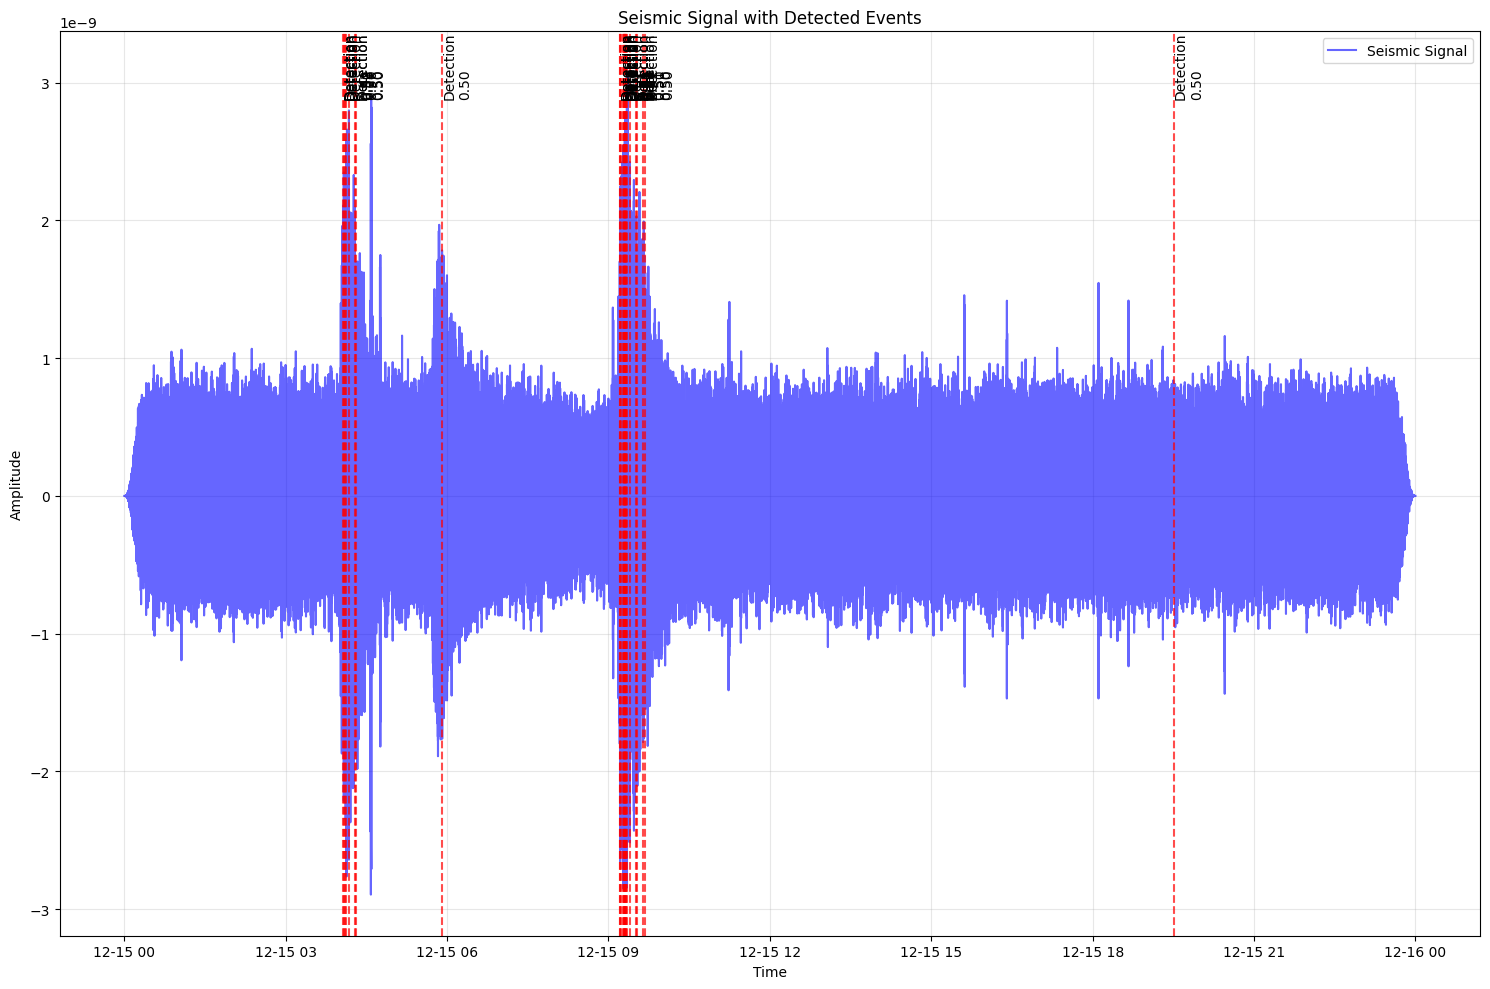


Detected quakes:
Time: 1974-12-15 04:03:33.893849, Confidence: 0.520
Time: 1974-12-15 04:05:04.007057, Confidence: 0.503
Time: 1974-12-15 04:06:34.120264, Confidence: 0.517
Time: 1974-12-15 04:07:04.158000, Confidence: 0.532
Time: 1974-12-15 04:10:04.384415, Confidence: 0.503
Time: 1974-12-15 04:17:34.950453, Confidence: 0.501
Time: 1974-12-15 04:18:04.988189, Confidence: 0.504
Time: 1974-12-15 05:54:42.271208, Confidence: 0.503
Time: 1974-12-15 09:12:27.176868, Confidence: 0.511
Time: 1974-12-15 09:12:57.214604, Confidence: 0.508
Time: 1974-12-15 09:14:27.327811, Confidence: 0.507
Time: 1974-12-15 09:16:27.478755, Confidence: 0.513
Time: 1974-12-15 09:16:57.516491, Confidence: 0.522
Time: 1974-12-15 09:17:27.554226, Confidence: 0.506
Time: 1974-12-15 09:17:57.591962, Confidence: 0.506
Time: 1974-12-15 09:18:27.629698, Confidence: 0.517
Time: 1974-12-15 09:19:27.705170, Confidence: 0.521
Time: 1974-12-15 09:19:57.742906, Confidence: 0.502
Time: 1974-12-15 09:20:27.780642, Confidence: 

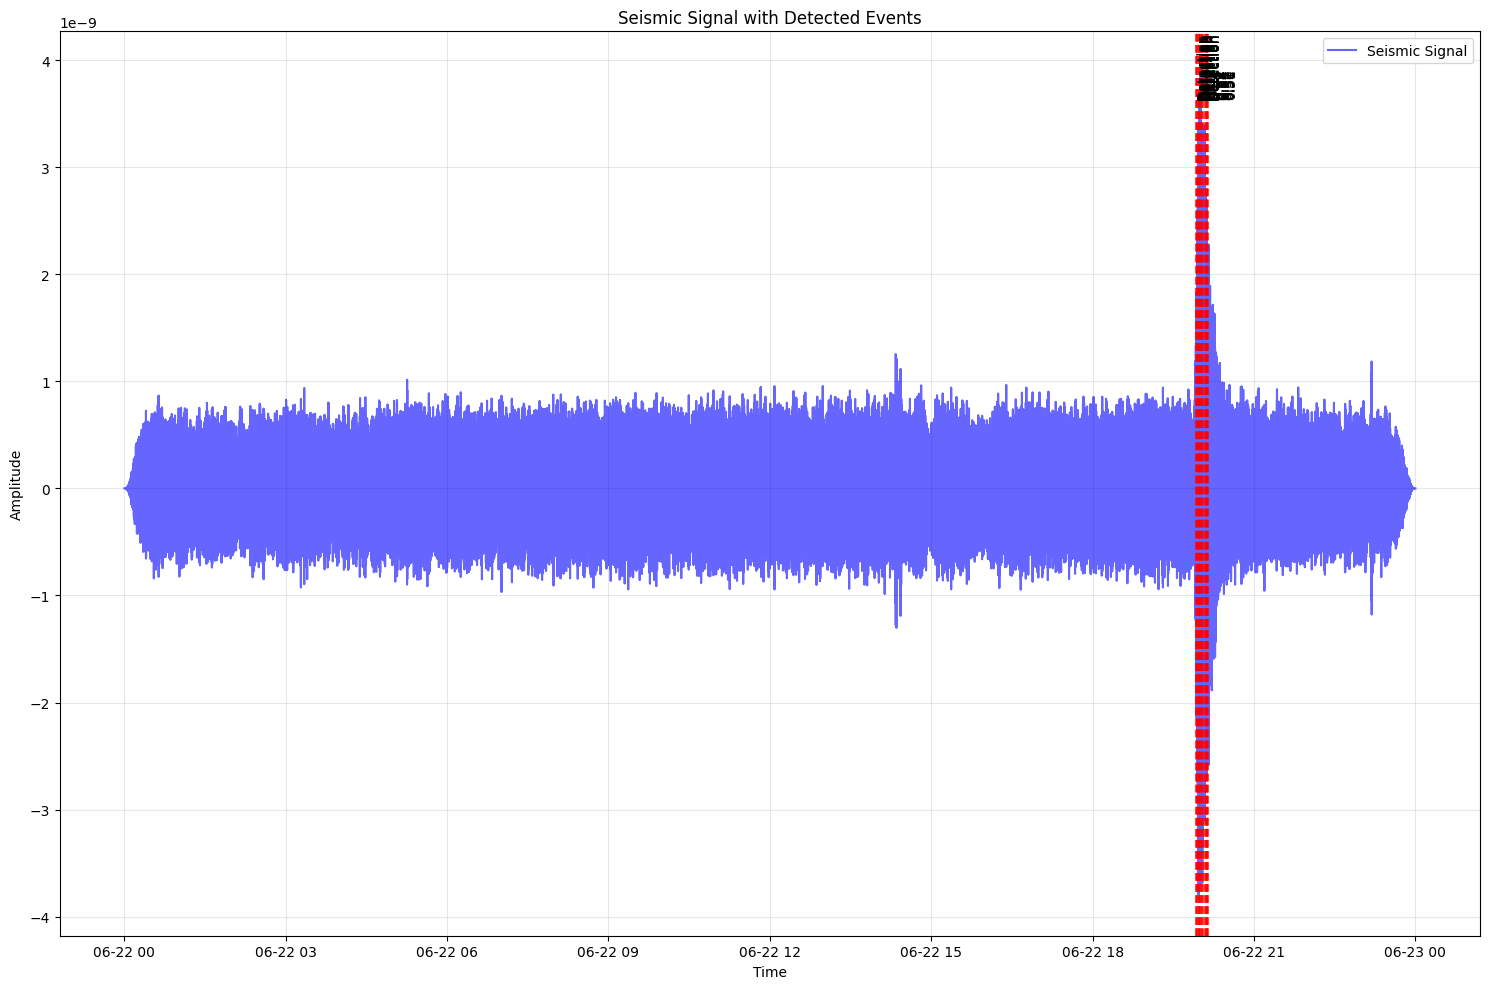


Detected quakes:
Time: 1975-06-22 19:55:15.698698, Confidence: 0.504
Time: 1975-06-22 19:56:15.774170, Confidence: 0.524
Time: 1975-06-22 19:56:45.811906, Confidence: 0.509
Time: 1975-06-22 19:58:15.925113, Confidence: 0.528
Time: 1975-06-22 19:58:45.962849, Confidence: 0.533
Time: 1975-06-22 19:59:16.000585, Confidence: 0.543
Time: 1975-06-22 20:00:16.076057, Confidence: 0.511
Time: 1975-06-22 20:01:46.189264, Confidence: 0.540
Time: 1975-06-22 20:02:16.227000, Confidence: 0.511
Time: 1975-06-22 20:03:46.340208, Confidence: 0.518
Time: 1975-06-22 20:06:16.528887, Confidence: 0.512
Time: 1975-06-22 20:06:46.566623, Confidence: 0.518
Time: 1975-06-22 20:07:16.604358, Confidence: 0.510
Time: 1975-06-22 20:07:46.642094, Confidence: 0.500
Time: 1975-06-22 20:08:16.679830, Confidence: 0.514


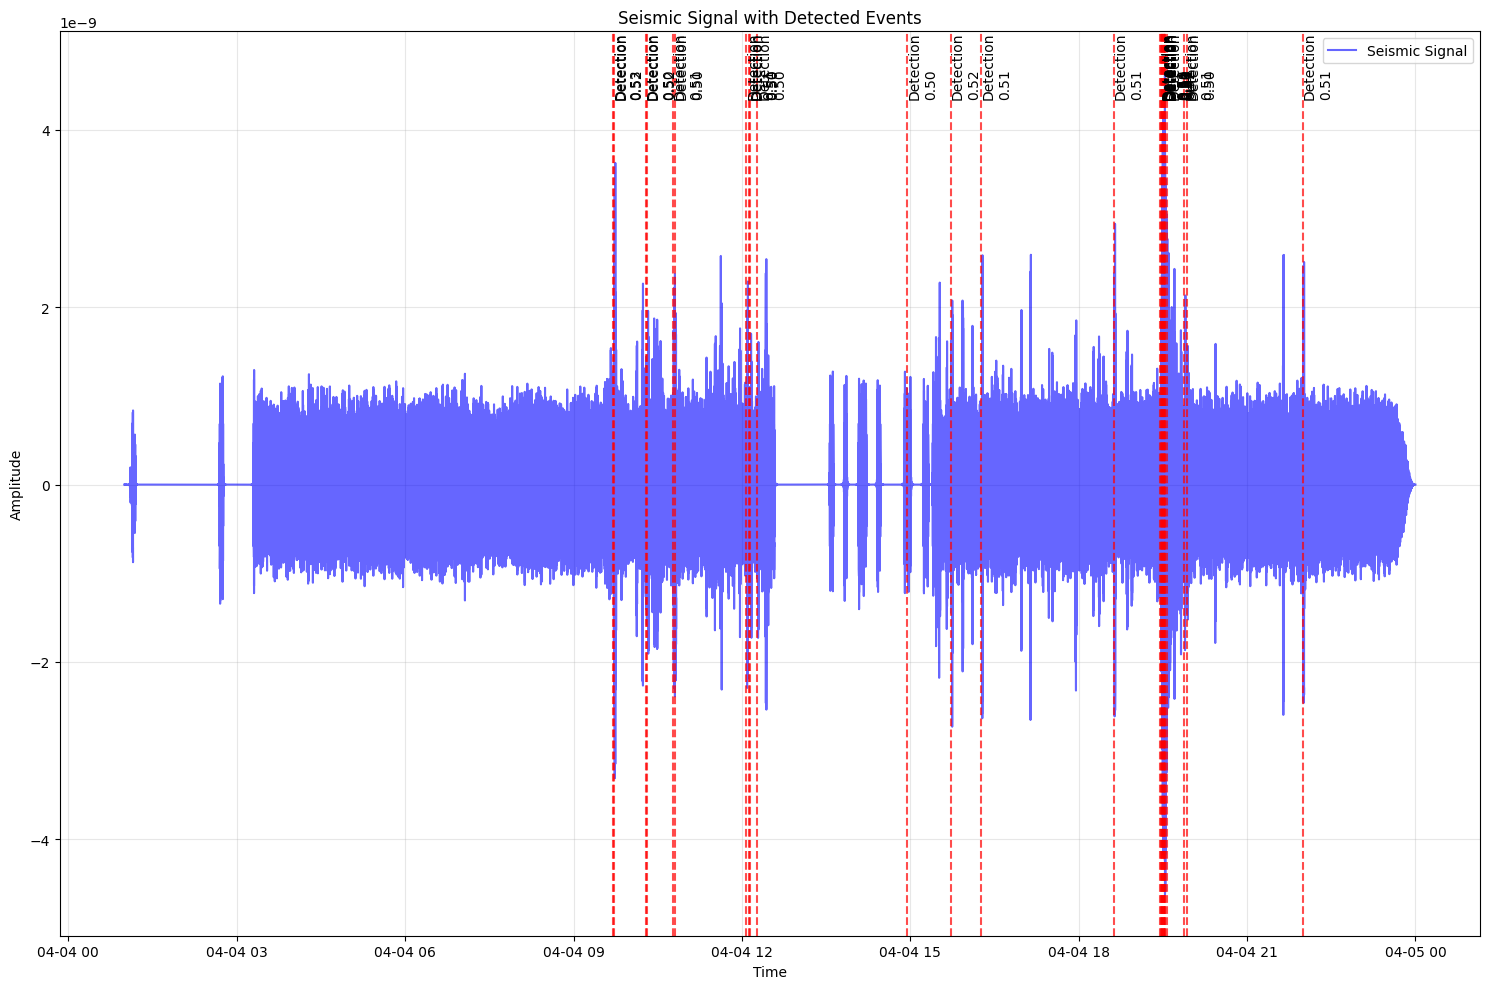


Detected quakes:
Time: 1973-04-04 09:42:37.728644, Confidence: 0.530
Time: 1973-04-04 09:43:37.804116, Confidence: 0.516
Time: 1973-04-04 10:17:10.332417, Confidence: 0.503
Time: 1973-04-04 10:18:40.445625, Confidence: 0.518
Time: 1973-04-04 10:46:12.521097, Confidence: 0.515
Time: 1973-04-04 10:48:12.672040, Confidence: 0.502
Time: 1973-04-04 12:04:48.445625, Confidence: 0.511
Time: 1973-04-04 12:07:48.672040, Confidence: 0.500
Time: 1973-04-04 12:08:48.747512, Confidence: 0.502
Time: 1973-04-04 12:16:19.313549, Confidence: 0.502
Time: 1973-04-04 14:57:01.426757, Confidence: 0.503
Time: 1973-04-04 15:43:34.936191, Confidence: 0.521
Time: 1973-04-04 16:16:07.389021, Confidence: 0.514
Time: 1973-04-04 18:37:48.068266, Confidence: 0.513
Time: 1973-04-04 19:27:21.804116, Confidence: 0.533
Time: 1973-04-04 19:28:21.879587, Confidence: 0.501
Time: 1973-04-04 19:28:51.917323, Confidence: 0.512
Time: 1973-04-04 19:29:21.955059, Confidence: 0.511
Time: 1973-04-04 19:29:51.992795, Confidence: 

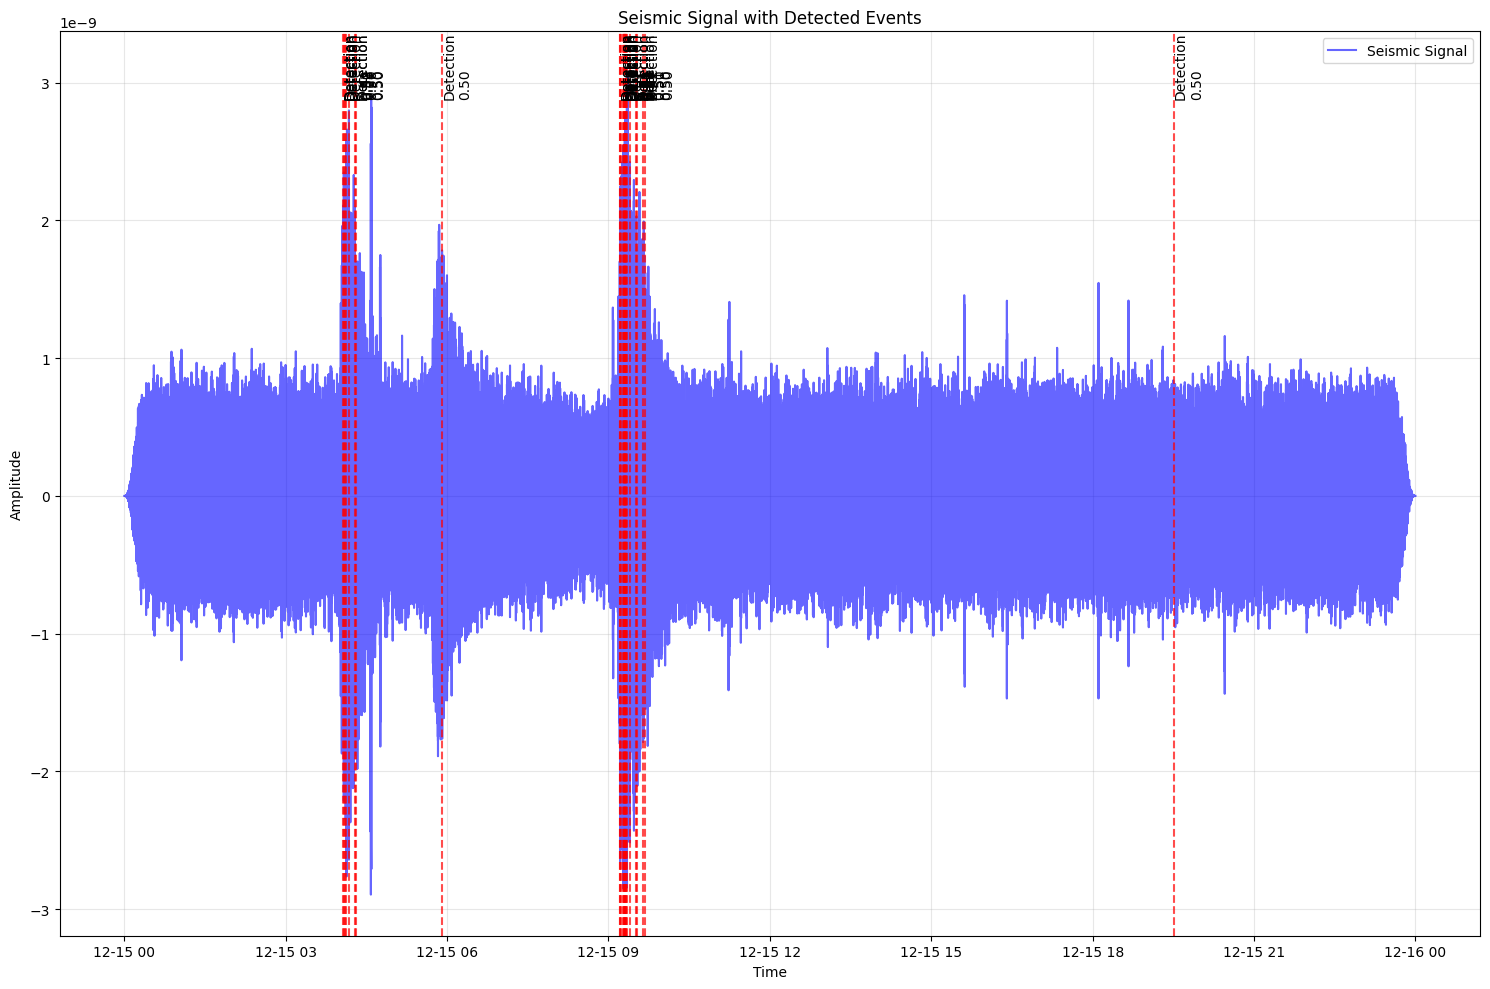


Detected quakes:
Time: 1974-12-15 04:03:33.893849, Confidence: 0.520
Time: 1974-12-15 04:05:04.007057, Confidence: 0.503
Time: 1974-12-15 04:06:34.120264, Confidence: 0.517
Time: 1974-12-15 04:07:04.158000, Confidence: 0.532
Time: 1974-12-15 04:10:04.384415, Confidence: 0.503
Time: 1974-12-15 04:17:34.950453, Confidence: 0.501
Time: 1974-12-15 04:18:04.988189, Confidence: 0.504
Time: 1974-12-15 05:54:42.271208, Confidence: 0.503
Time: 1974-12-15 09:12:27.176868, Confidence: 0.511
Time: 1974-12-15 09:12:57.214604, Confidence: 0.508
Time: 1974-12-15 09:14:27.327811, Confidence: 0.507
Time: 1974-12-15 09:16:27.478755, Confidence: 0.513
Time: 1974-12-15 09:16:57.516491, Confidence: 0.522
Time: 1974-12-15 09:17:27.554226, Confidence: 0.506
Time: 1974-12-15 09:17:57.591962, Confidence: 0.506
Time: 1974-12-15 09:18:27.629698, Confidence: 0.517
Time: 1974-12-15 09:19:27.705170, Confidence: 0.521
Time: 1974-12-15 09:19:57.742906, Confidence: 0.502
Time: 1974-12-15 09:20:27.780642, Confidence: 

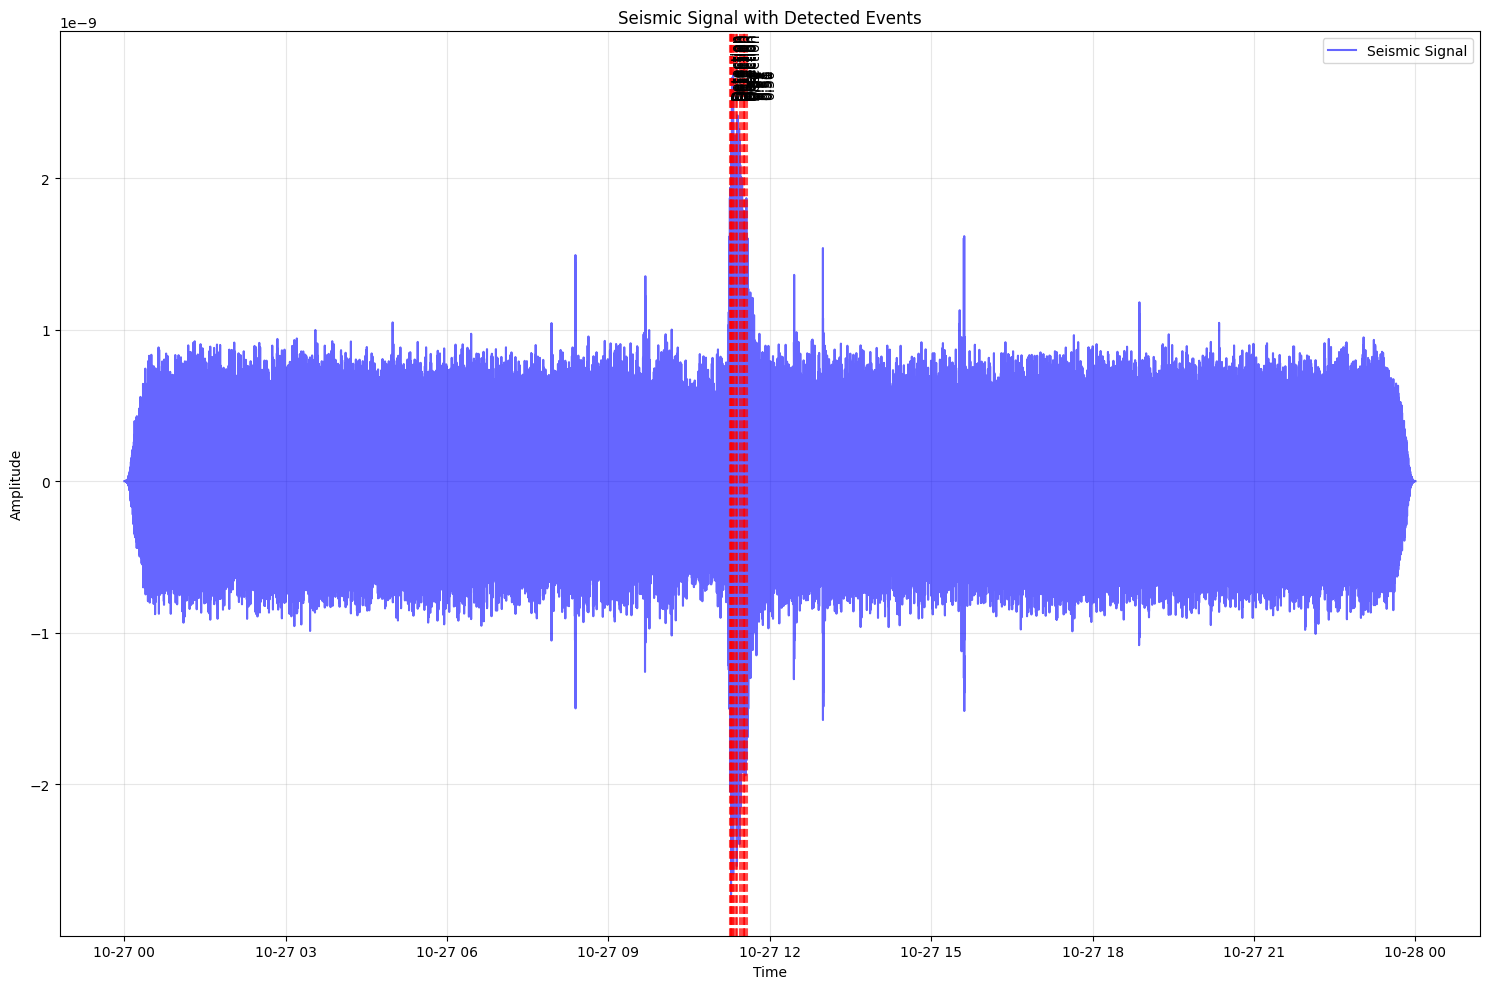


Detected quakes:
Time: 1973-10-27 11:15:06.818151, Confidence: 0.518
Time: 1973-10-27 11:16:36.931358, Confidence: 0.510
Time: 1973-10-27 11:17:06.969094, Confidence: 0.503
Time: 1973-10-27 11:17:37.006830, Confidence: 0.523
Time: 1973-10-27 11:19:07.120038, Confidence: 0.508
Time: 1973-10-27 11:20:07.195509, Confidence: 0.509
Time: 1973-10-27 11:22:07.346453, Confidence: 0.520
Time: 1973-10-27 11:23:07.421925, Confidence: 0.511
Time: 1973-10-27 11:26:37.686075, Confidence: 0.517
Time: 1973-10-27 11:29:07.874755, Confidence: 0.506
Time: 1973-10-27 11:30:37.987962, Confidence: 0.506
Time: 1973-10-27 11:31:08.025698, Confidence: 0.503
Time: 1973-10-27 11:32:08.101170, Confidence: 0.506
Time: 1973-10-27 11:34:38.289849, Confidence: 0.501


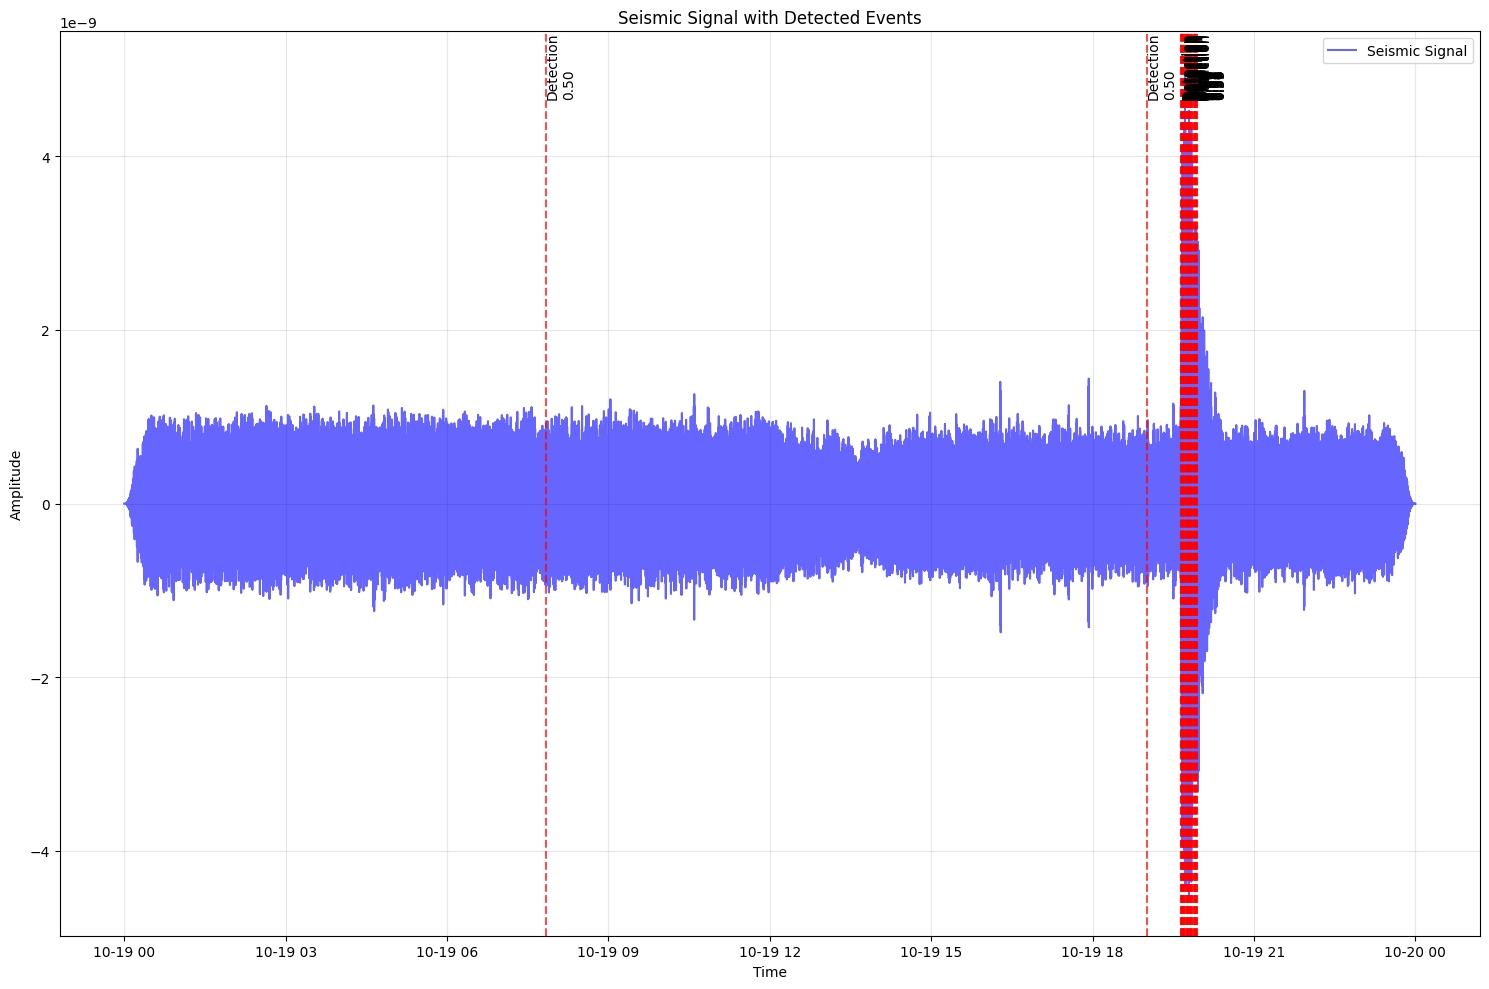


Detected quakes:
Time: 1974-10-19 07:49:51.237453, Confidence: 0.504
Time: 1974-10-19 19:00:11.765755, Confidence: 0.501
Time: 1974-10-19 19:38:14.633679, Confidence: 0.511
Time: 1974-10-19 19:38:44.671415, Confidence: 0.552
Time: 1974-10-19 19:39:14.709151, Confidence: 0.532
Time: 1974-10-19 19:39:44.746887, Confidence: 0.524
Time: 1974-10-19 19:40:14.784623, Confidence: 0.522
Time: 1974-10-19 19:41:14.860094, Confidence: 0.601
Time: 1974-10-19 19:41:44.897830, Confidence: 0.555
Time: 1974-10-19 19:42:14.935566, Confidence: 0.534
Time: 1974-10-19 19:43:15.011038, Confidence: 0.504
Time: 1974-10-19 19:43:45.048774, Confidence: 0.531
Time: 1974-10-19 19:45:15.161981, Confidence: 0.500
Time: 1974-10-19 19:45:45.199717, Confidence: 0.533
Time: 1974-10-19 19:46:15.237453, Confidence: 0.524
Time: 1974-10-19 19:46:45.275189, Confidence: 0.504
Time: 1974-10-19 19:47:45.350660, Confidence: 0.520
Time: 1974-10-19 19:48:15.388396, Confidence: 0.520
Time: 1974-10-19 19:48:45.426132, Confidence: 

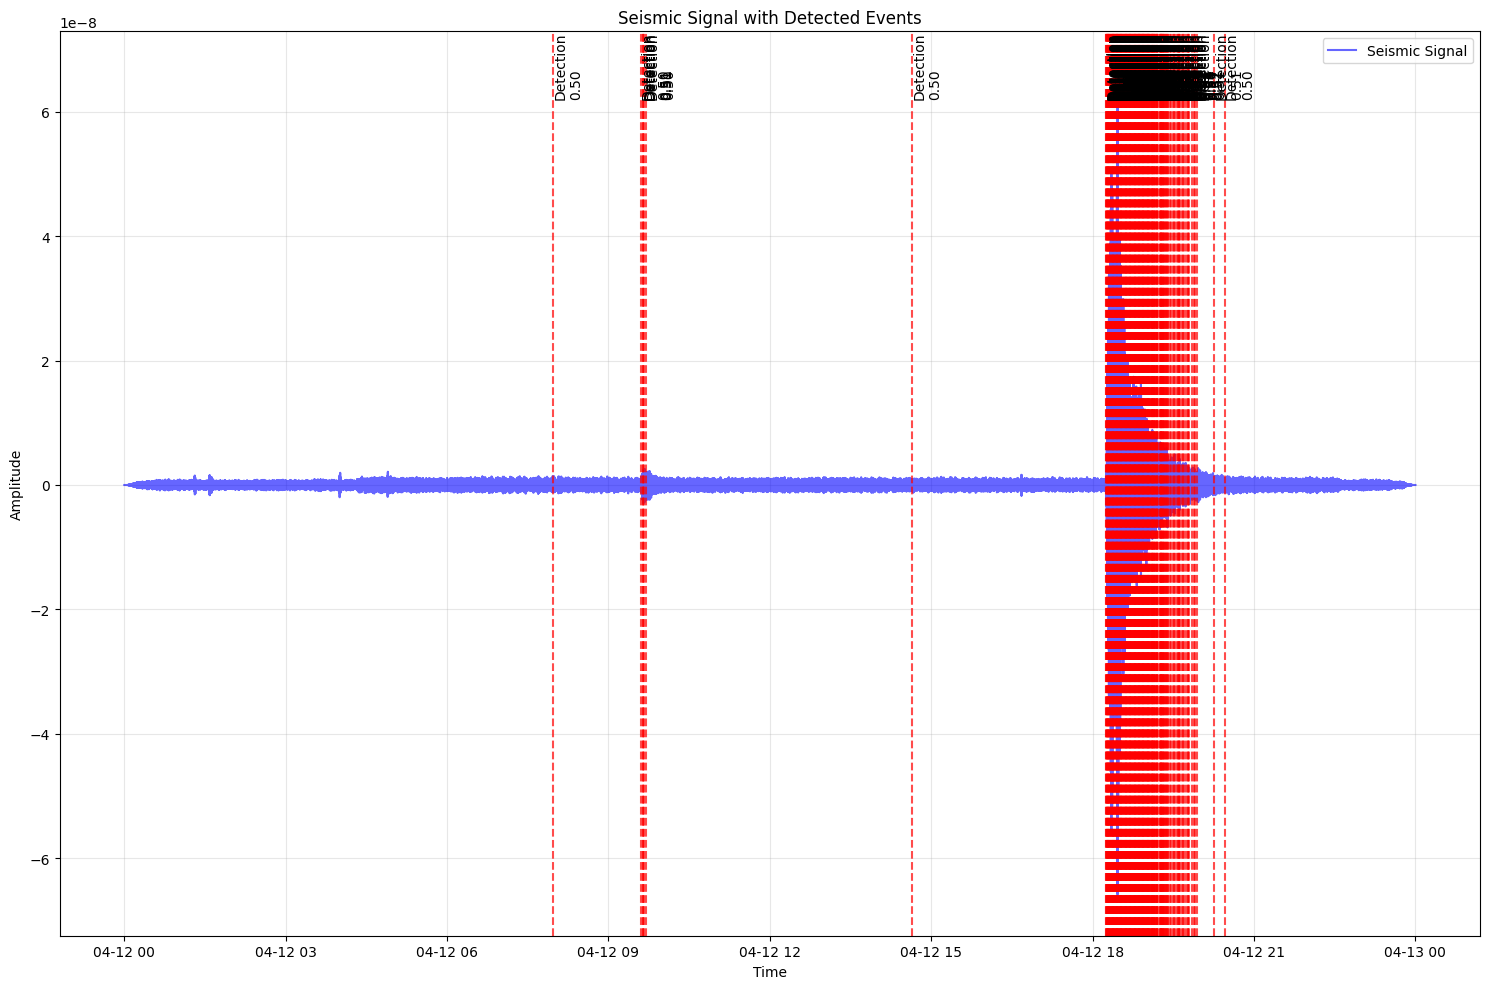


Detected quakes:
Time: 1975-04-12 07:58:21.951962, Confidence: 0.500
Time: 1975-04-12 09:35:59.310453, Confidence: 0.504
Time: 1975-04-12 09:37:59.461396, Confidence: 0.510
Time: 1975-04-12 09:38:59.536868, Confidence: 0.512
Time: 1975-04-12 09:39:29.574604, Confidence: 0.514
Time: 1975-04-12 09:41:29.725547, Confidence: 0.505
Time: 1975-04-12 14:38:52.140642, Confidence: 0.503
Time: 1975-04-12 18:14:38.404792, Confidence: 0.574
Time: 1975-04-12 18:15:08.442528, Confidence: 0.601
Time: 1975-04-12 18:15:38.480264, Confidence: 0.590
Time: 1975-04-12 18:16:08.518000, Confidence: 0.613
Time: 1975-04-12 18:16:38.555736, Confidence: 0.612
Time: 1975-04-12 18:17:08.593472, Confidence: 0.591
Time: 1975-04-12 18:17:38.631208, Confidence: 0.610
Time: 1975-04-12 18:18:08.668943, Confidence: 0.582
Time: 1975-04-12 18:18:38.706679, Confidence: 0.610
Time: 1975-04-12 18:19:08.744415, Confidence: 0.629
Time: 1975-04-12 18:19:38.782151, Confidence: 0.584
Time: 1975-04-12 18:20:08.819887, Confidence: 

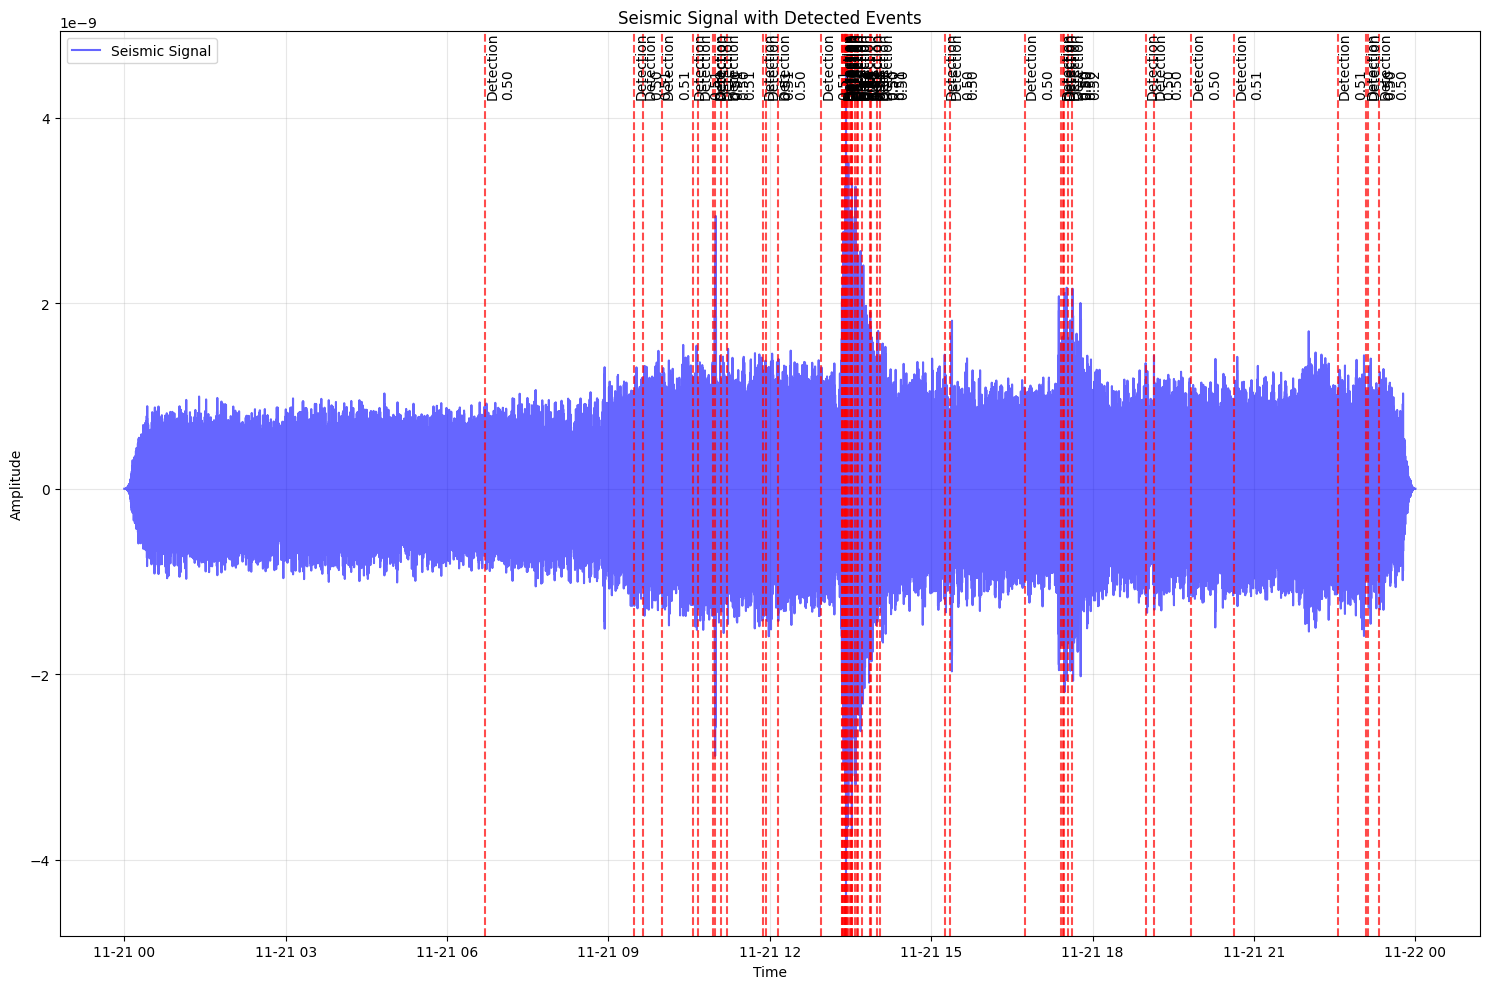


Detected quakes:
Time: 1974-11-21 06:42:46.355849, Confidence: 0.502
Time: 1974-11-21 09:28:58.884151, Confidence: 0.502
Time: 1974-11-21 09:38:59.638868, Confidence: 0.506
Time: 1974-11-21 09:59:31.186038, Confidence: 0.511
Time: 1974-11-21 10:34:03.789811, Confidence: 0.506
Time: 1974-11-21 10:40:04.242642, Confidence: 0.502
Time: 1974-11-21 10:57:05.525660, Confidence: 0.501
Time: 1974-11-21 10:58:35.638868, Confidence: 0.514
Time: 1974-11-21 11:05:36.167170, Confidence: 0.502
Time: 1974-11-21 11:12:06.657736, Confidence: 0.508
Time: 1974-11-21 11:52:09.676604, Confidence: 0.508
Time: 1974-11-21 11:56:09.978491, Confidence: 0.511
Time: 1974-11-21 12:08:40.921887, Confidence: 0.503
Time: 1974-11-21 12:57:14.582264, Confidence: 0.508
Time: 1974-11-21 13:20:16.318113, Confidence: 0.511
Time: 1974-11-21 13:20:46.355849, Confidence: 0.511
Time: 1974-11-21 13:21:46.431321, Confidence: 0.512
Time: 1974-11-21 13:22:46.506792, Confidence: 0.521
Time: 1974-11-21 13:23:46.582264, Confidence: 

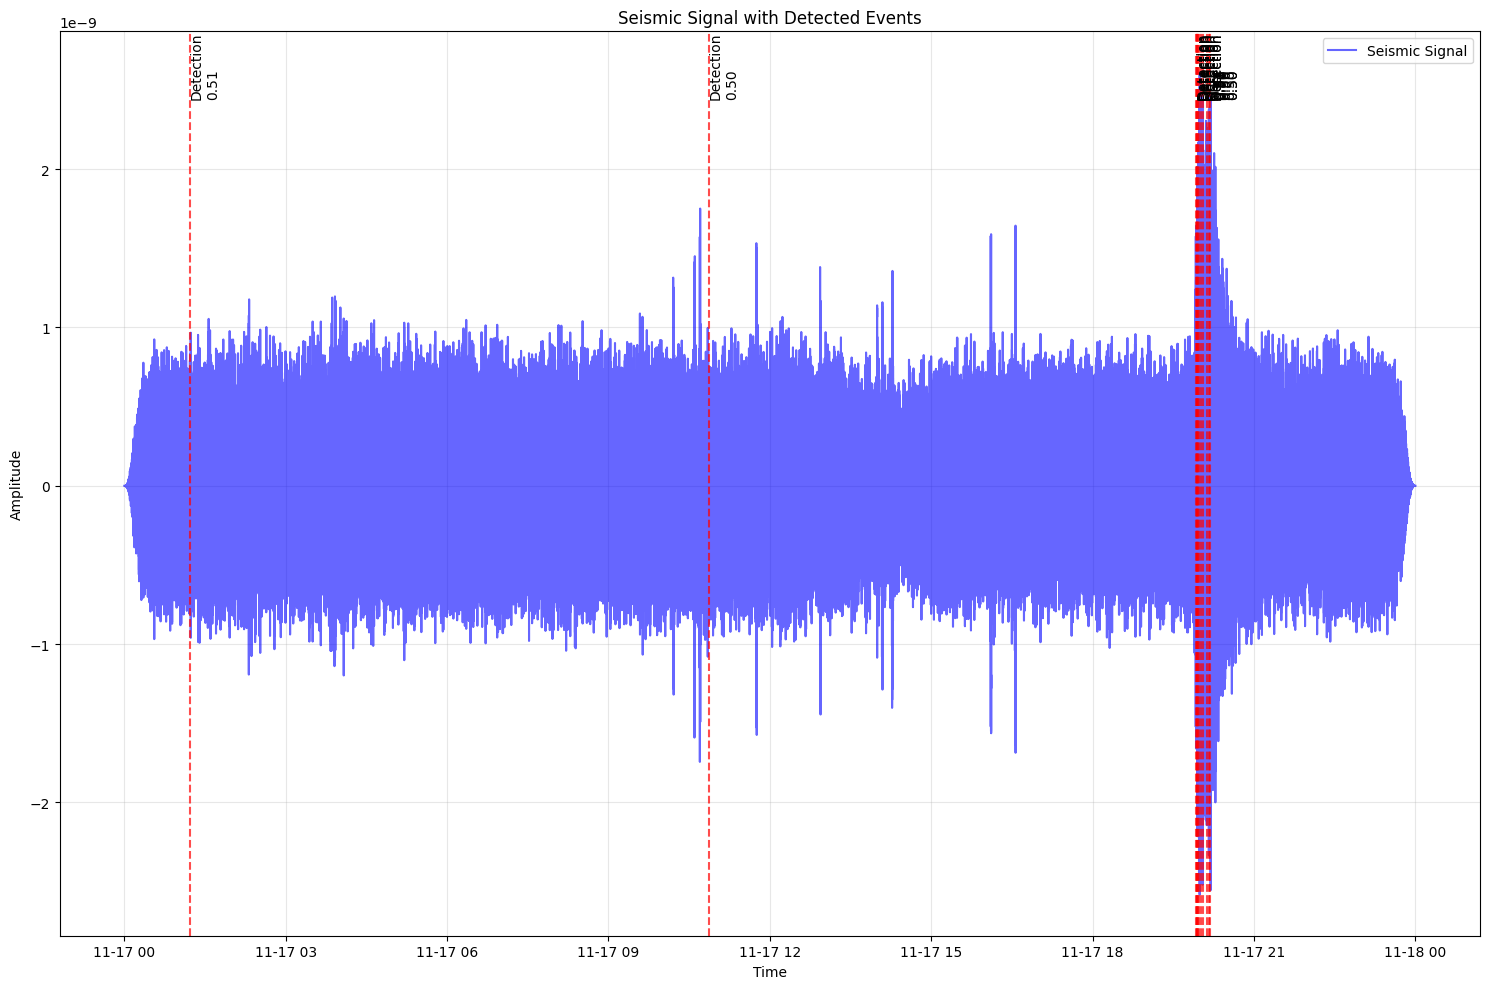


Detected quakes:
Time: 1974-11-17 01:12:50.984925, Confidence: 0.507
Time: 1974-11-17 10:52:04.645302, Confidence: 0.503
Time: 1974-11-17 19:55:15.588698, Confidence: 0.518
Time: 1974-11-17 19:56:15.664170, Confidence: 0.509
Time: 1974-11-17 19:56:45.701906, Confidence: 0.517
Time: 1974-11-17 19:57:15.739642, Confidence: 0.503
Time: 1974-11-17 19:58:45.852849, Confidence: 0.502
Time: 1974-11-17 20:01:16.041528, Confidence: 0.502
Time: 1974-11-17 20:03:16.192472, Confidence: 0.502
Time: 1974-11-17 20:07:16.494358, Confidence: 0.500
Time: 1974-11-17 20:10:16.720774, Confidence: 0.501
Time: 1974-11-17 20:10:46.758509, Confidence: 0.502


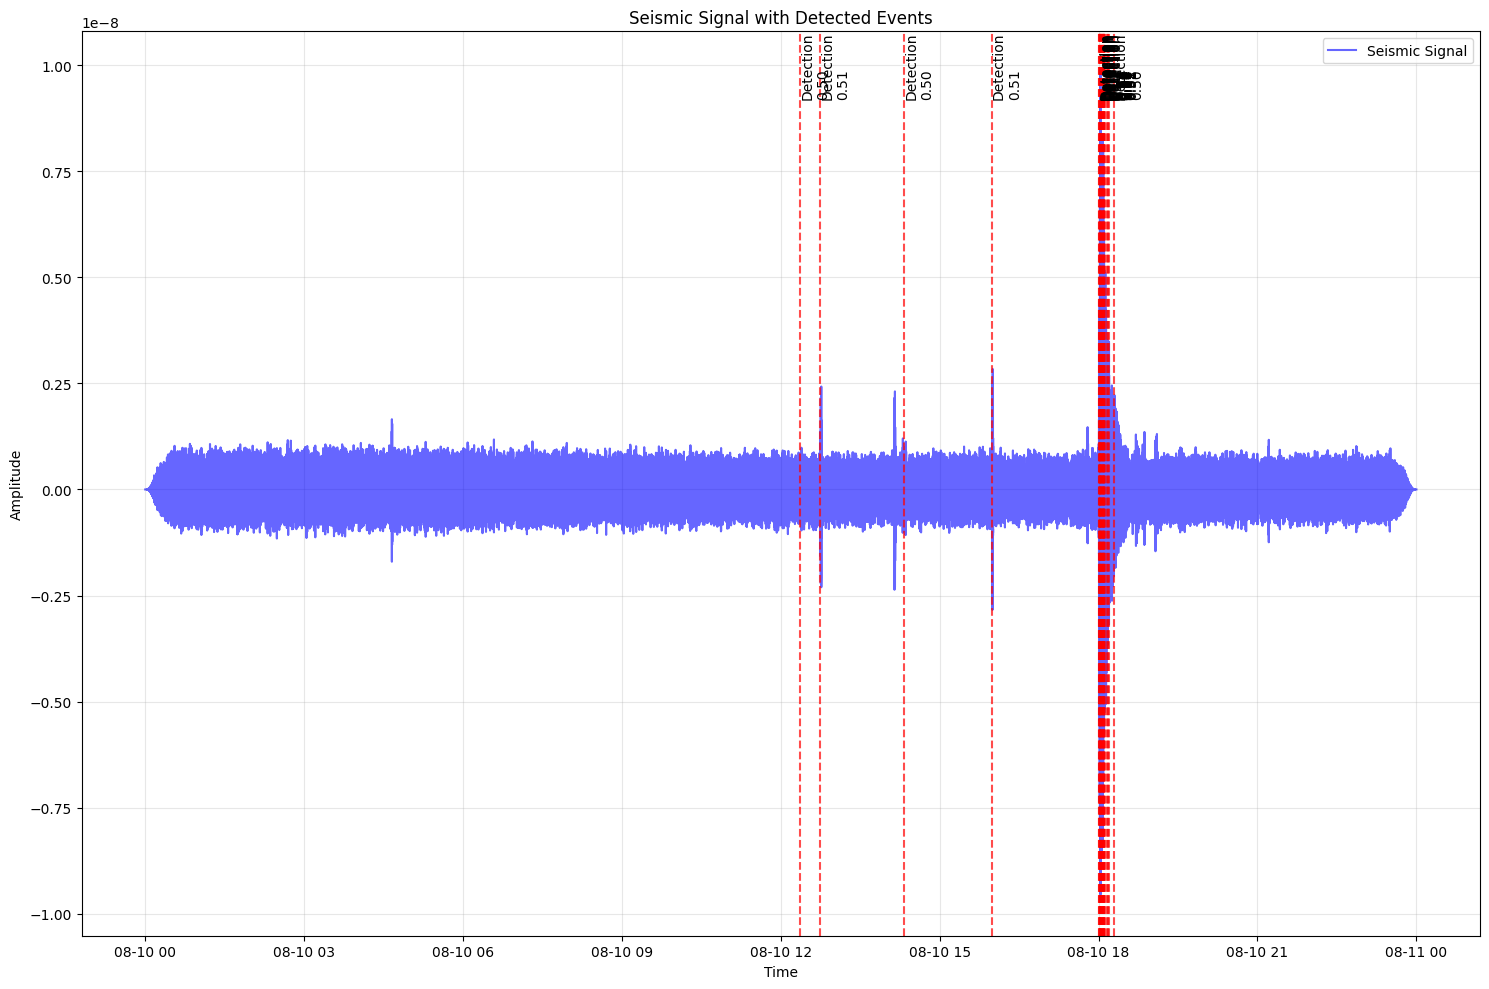


Detected quakes:
Time: 1973-08-10 12:22:11.826755, Confidence: 0.503
Time: 1973-08-10 12:44:43.524868, Confidence: 0.514
Time: 1973-08-10 14:19:50.694679, Confidence: 0.500
Time: 1973-08-10 15:58:58.166377, Confidence: 0.513
Time: 1973-08-10 18:00:07.298453, Confidence: 0.537
Time: 1973-08-10 18:00:37.336189, Confidence: 0.531
Time: 1973-08-10 18:01:07.373925, Confidence: 0.554
Time: 1973-08-10 18:01:37.411660, Confidence: 0.542
Time: 1973-08-10 18:02:07.449396, Confidence: 0.530
Time: 1973-08-10 18:02:37.487132, Confidence: 0.535
Time: 1973-08-10 18:03:07.524868, Confidence: 0.602
Time: 1973-08-10 18:03:37.562604, Confidence: 0.534
Time: 1973-08-10 18:04:07.600340, Confidence: 0.573
Time: 1973-08-10 18:04:37.638075, Confidence: 0.520
Time: 1973-08-10 18:05:07.675811, Confidence: 0.543
Time: 1973-08-10 18:05:37.713547, Confidence: 0.571
Time: 1973-08-10 18:06:07.751283, Confidence: 0.521
Time: 1973-08-10 18:06:37.789019, Confidence: 0.538
Time: 1973-08-10 18:07:37.864491, Confidence: 

In [77]:
model_path = MODEL_NAME + ".keras"
scaler_path = MODEL_NAME + "_scaler.pkl"

# loop over all csv files in test data,
# preprocess the dataset and run the inference
data_dir = "/content/space_apps_2024_seismic_detection/data/lunar/test/data/S15_GradeA/"
for file in os.listdir(data_dir):
    if file.endswith('.csv'):
        new_data = load_dataset(
            pd.read_csv(data_dir + file)
        )
        detections = run_inference_engine_v1(model_path, scaler_path, new_data)

### SeismicInferenceEngineV2

In [81]:
class SeismicInferenceEngineV2:
    def __init__(
        self,
        model: tf.keras.Model,
        window_size: int = 1000,
        overlap: float = 0.8,  # Higher overlap for better detection
        detection_threshold: float = 0.5,
        scaler: StandardScaler = None
    ):
        self.model = model
        self.window_size = window_size
        self.overlap = overlap
        self.stride = int(window_size * (1 - overlap))
        self.detection_threshold = detection_threshold
        self.scaler = scaler

    def prepare_inference_windows(
        self,
        data: pd.DataFrame
    ) -> Tuple[np.ndarray, List[datetime]]:
        """
        Prepare sliding windows for inference and keep track of their timestamps.
        """
        windows = []
        window_times = []

        for i in range(0, len(data) - self.window_size, self.stride):
            window = data.iloc[i:i + self.window_size]

            if len(window) == self.window_size:
                # Store the center timestamp of the window
                center_time = window['time_abs'].iloc[self.window_size // 2]
                window_times.append(center_time)

                # Extract and normalize the amplitude data
                amplitude_window = window[['amplitude']].values
                windows.append(amplitude_window)

        X = np.array(windows)

        # Normalize each window independently
        X_reshaped = X.reshape(-1, X.shape[-1])
        X_scaled = self.scaler.transform(X_reshaped)
        X = X_scaled.reshape(X.shape)

        return X, window_times

    def detect_quakes(
        self,
        data: pd.DataFrame,
        plot_results: bool = True,
        figsize: Tuple[int, int] = (15, 10)
    ) -> pd.DataFrame:
        """
        Detect quakes in the input data and optionally plot the results.

        Args:
            data: DataFrame with columns ['time_abs', 'amplitude']
            plot_results: Whether to show the plot
            figsize: Size of the plot figure

        Returns:
            DataFrame with detected quake timestamps and confidence scores
        """
        # Prepare windows for inference
        X, window_times = self.prepare_inference_windows(data)

        # Get model predictions
        predictions = self.model.predict(X, verbose=0)

        # Find windows where prediction exceeds threshold
        detections = []
        for time, pred in zip(window_times, predictions):
            if pred[0] >= self.detection_threshold:
                detections.append({
                    'detection_time': time,
                    'confidence': float(pred[0])
                })

        # Convert detections to DataFrame
        detection_df = pd.DataFrame(detections)

        # Handle multiple valid windows
        if len(detection_df) > 0:
            detection_df = self._extend_detection_windows(detection_df)

        # Plot if requested
        if plot_results:
            self.plot_detections(data, detection_df, figsize)

        return detection_df

    def _extend_detection_windows(
        self,
        detections: pd.DataFrame,
        merge_window: timedelta = timedelta(seconds=100)
    ) -> pd.DataFrame:
        """
        Extend detection windows to highlight continuous activity
        until no detection is found for the next 60 seconds.
        """
        detections = detections.sort_values('detection_time')
        extended_windows = []
        current_window = [detections.iloc[0]['detection_time'], detections.iloc[0]['detection_time']]

        for i in range(1, len(detections)):
            if detections.iloc[i]['detection_time'] - current_window[1] <= merge_window:
                # Extend current window
                current_window[1] = detections.iloc[i]['detection_time']
            else:
                # Save the current window if it spans more than one detection
                if current_window[1] - current_window[0] >= timedelta(seconds=60):
                    extended_windows.append(current_window)
                # Start a new window
                current_window = [detections.iloc[i]['detection_time'], detections.iloc[i]['detection_time']]

        # Append the last window if valid
        if current_window[1] - current_window[0] >= timedelta(seconds=60):
            extended_windows.append(current_window)

        return pd.DataFrame(extended_windows, columns=['start_time', 'end_time'])

    def plot_detections(
        self,
        data: pd.DataFrame,
        detections: pd.DataFrame,
        figsize: Tuple[int, int] = (15, 10)
    ) -> None:
        """
        Plot the seismic data and highlight regions with detections.
        """
        plt.figure(figsize=figsize)

        # Plot amplitude data
        plt.plot(data['time_abs'], data['amplitude'], 'b-', alpha=0.6, label='Seismic Signal')

        # Highlight detected regions
        if len(detections) > 0:
            for _, detection in detections.iterrows():
                plt.axvspan(
                    detection['start_time'] - timedelta(seconds=60*10),
                    detection['end_time'] + timedelta(seconds=60*40),
                    color='yellow',
                    alpha=0.3,
                )

        plt.title('Seismic Signal with Detected Regions')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [86]:
def run_inference_engine_v2(model_path: str, scaler_path, new_data: pd.DataFrame):
    # Load the trained model
    model = tf.keras.models.load_model(model_path)

    # Load the scaler
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # Initialize inference engine
    engine = SeismicInferenceEngineV2(
        model=model,
        window_size=1000,
        overlap=0.8,
        detection_threshold=0.5,
        scaler=scaler  # Use the same scaler used during training
    )

    # Run detection
    detections = engine.detect_quakes(
        data=new_data,
        plot_results=True,
        figsize=(15, 10)
    )

    return detections

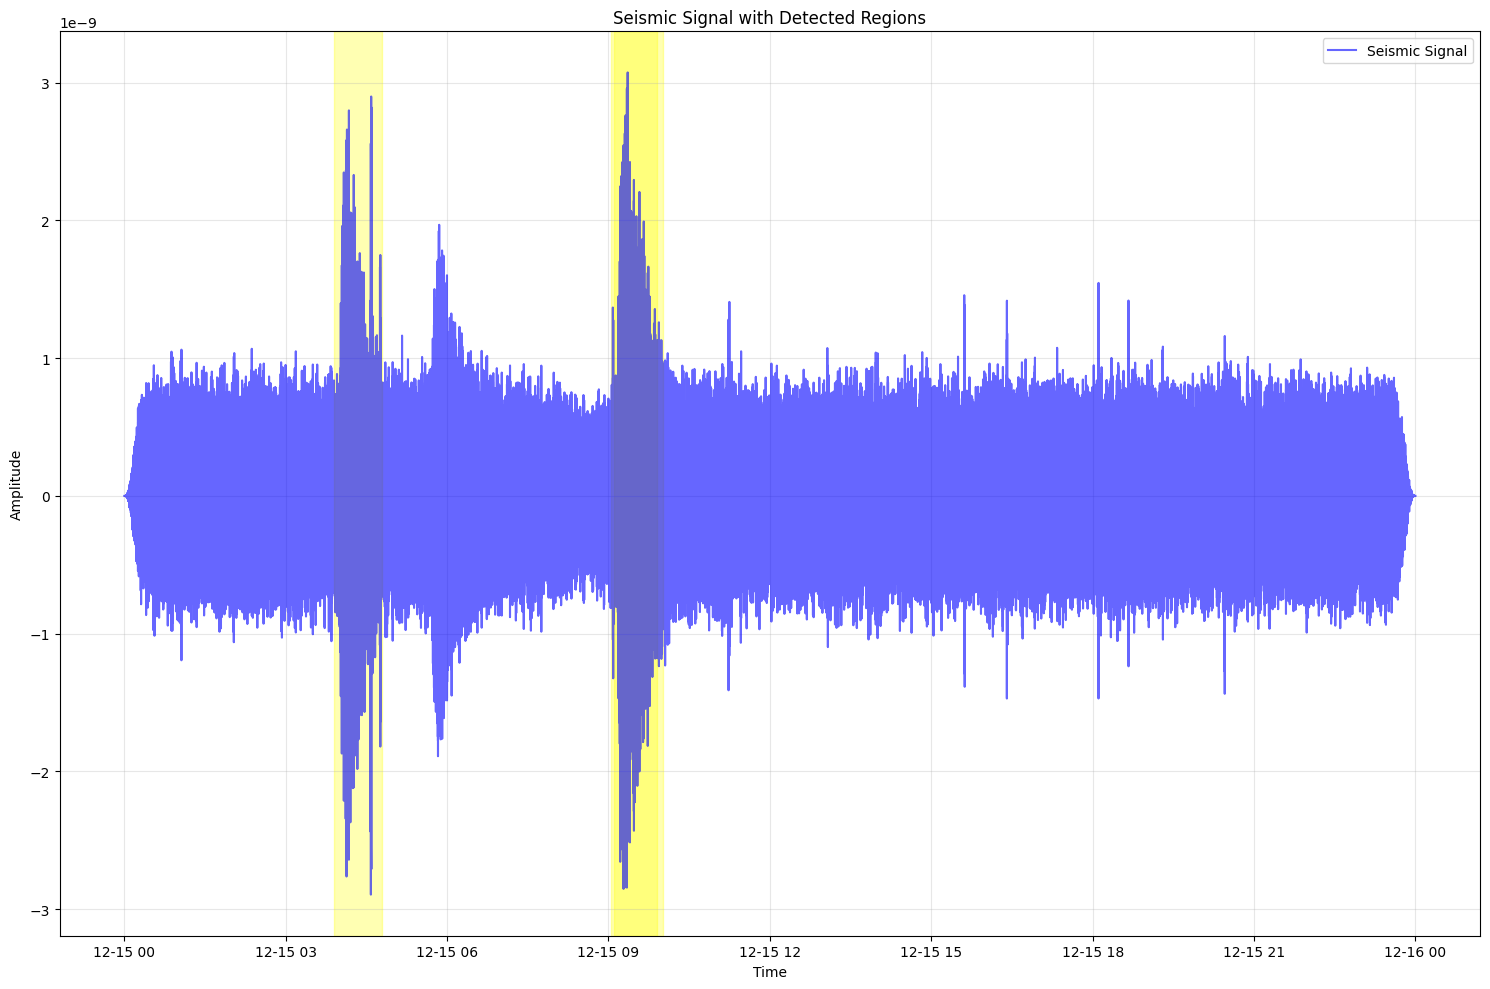

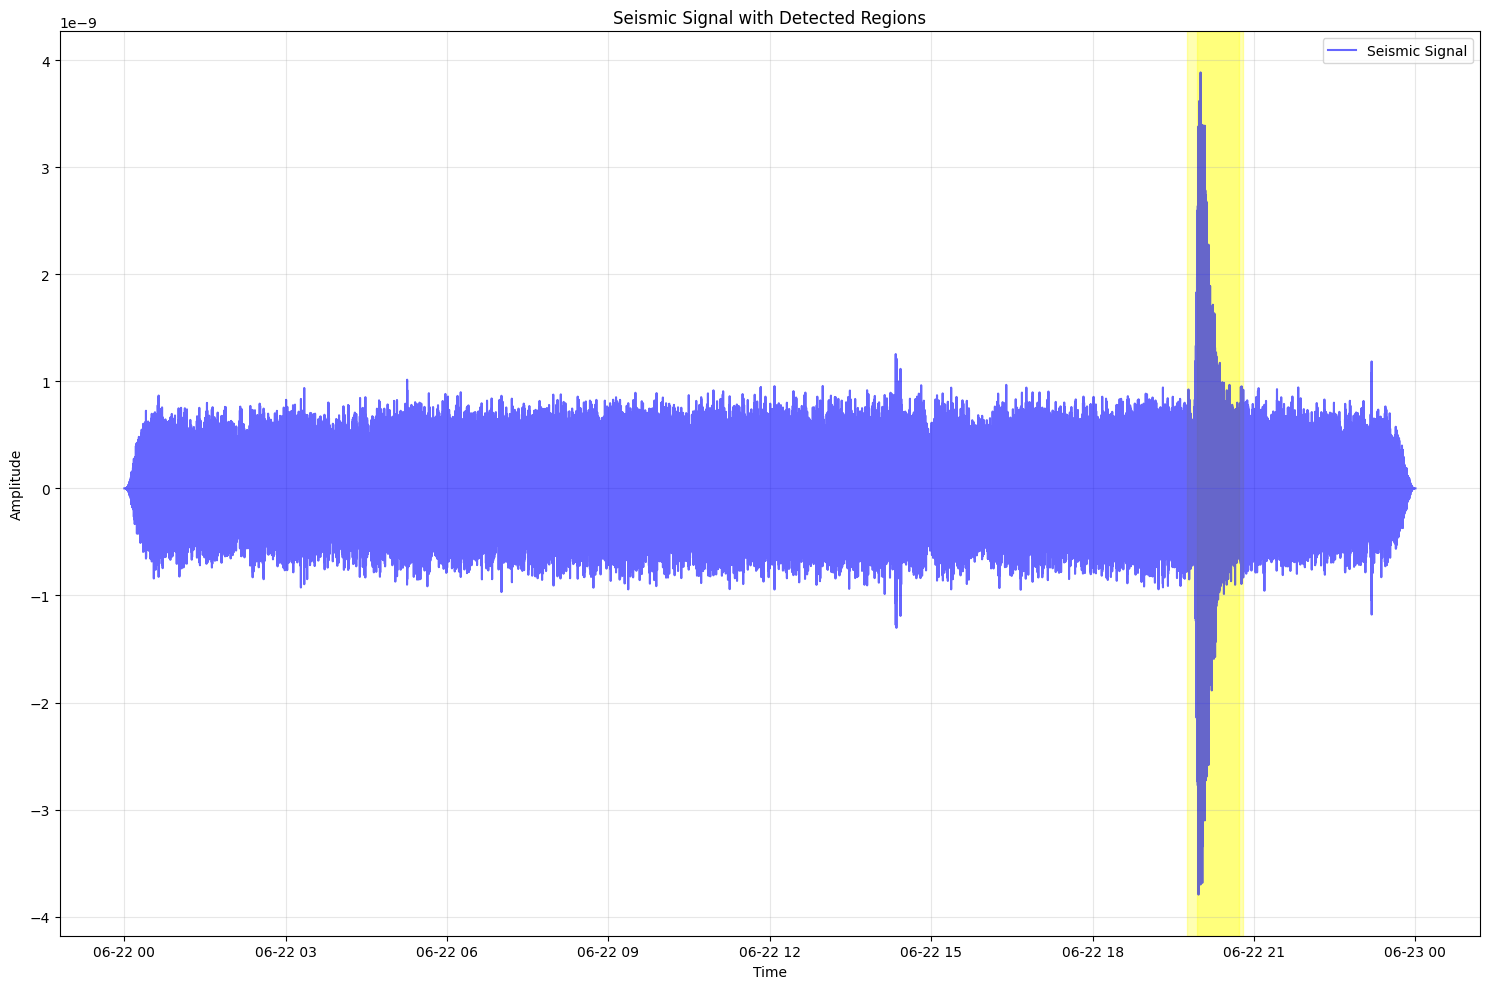

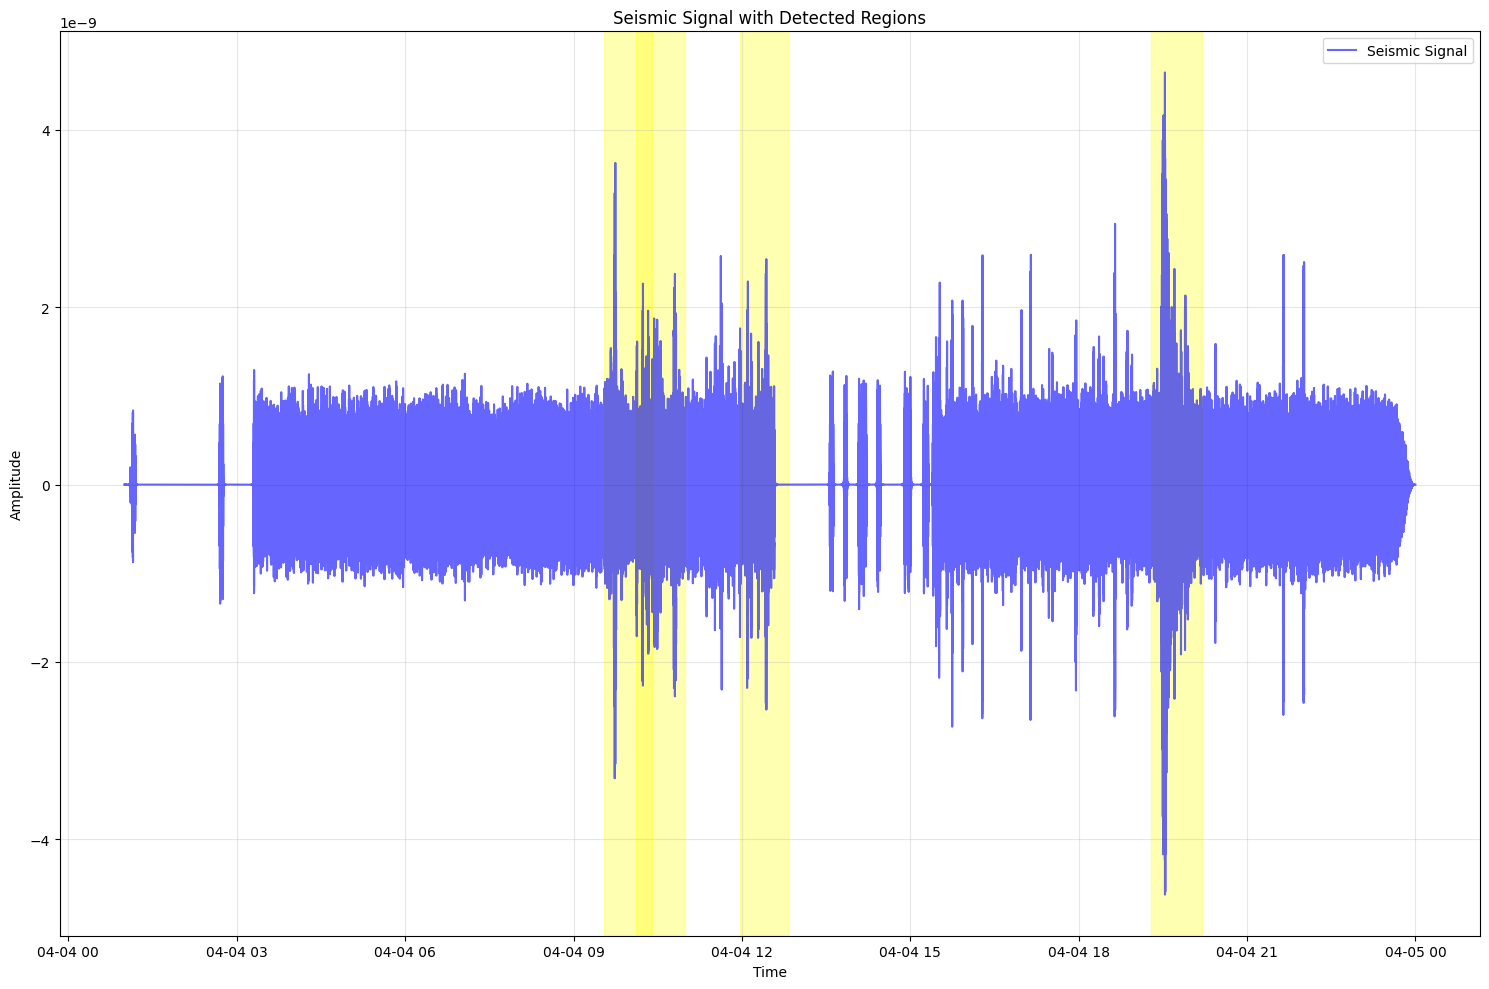

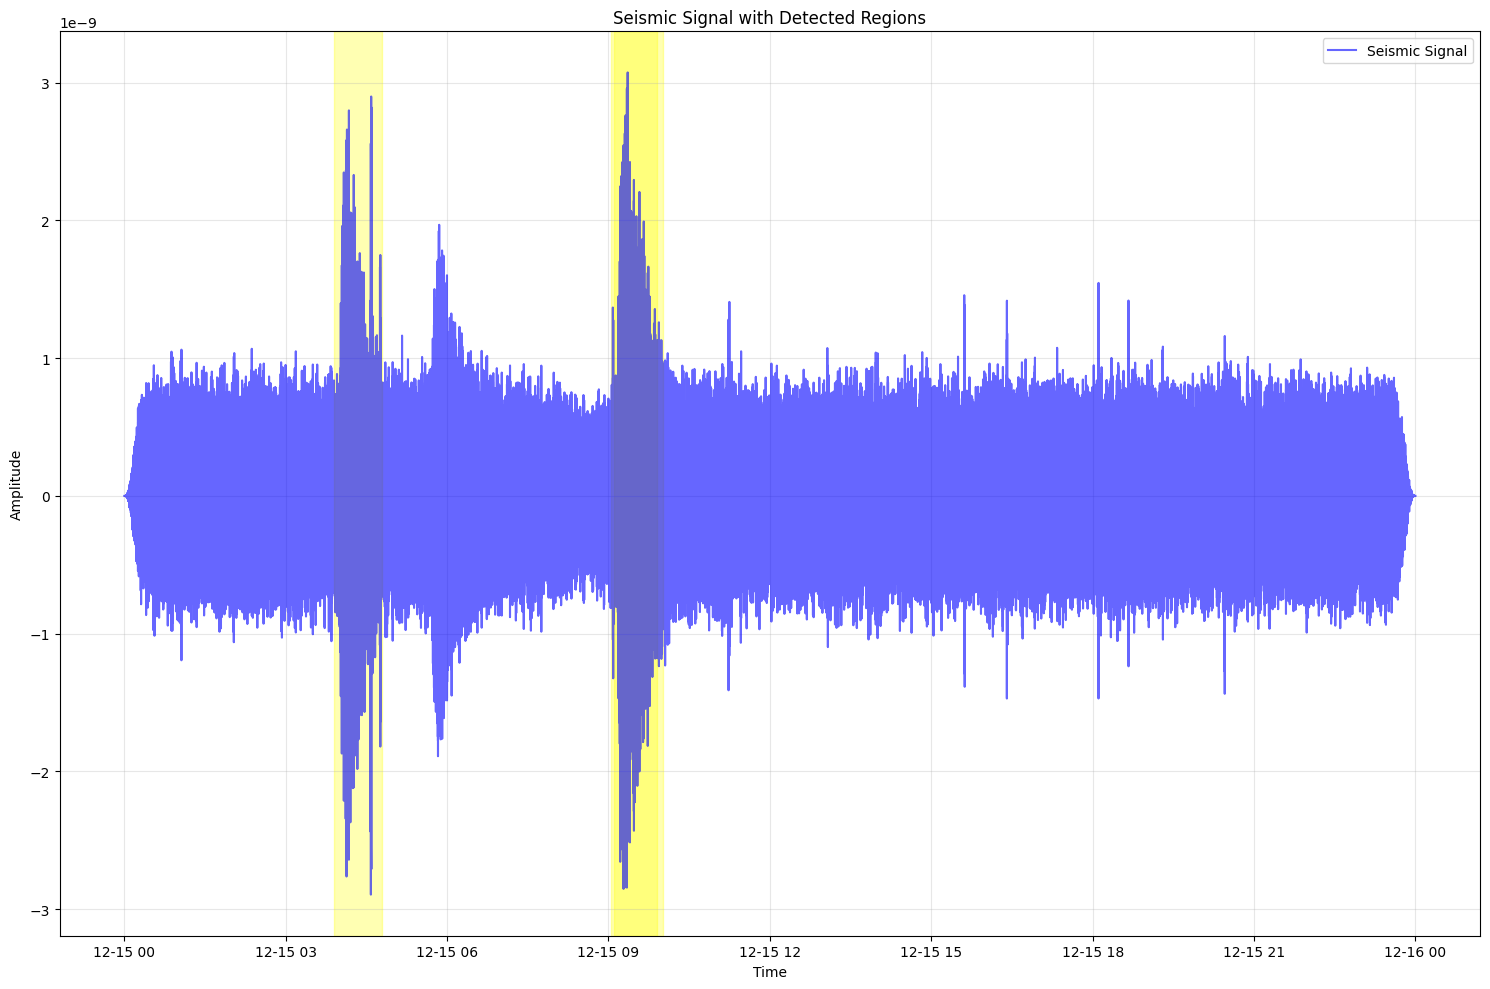

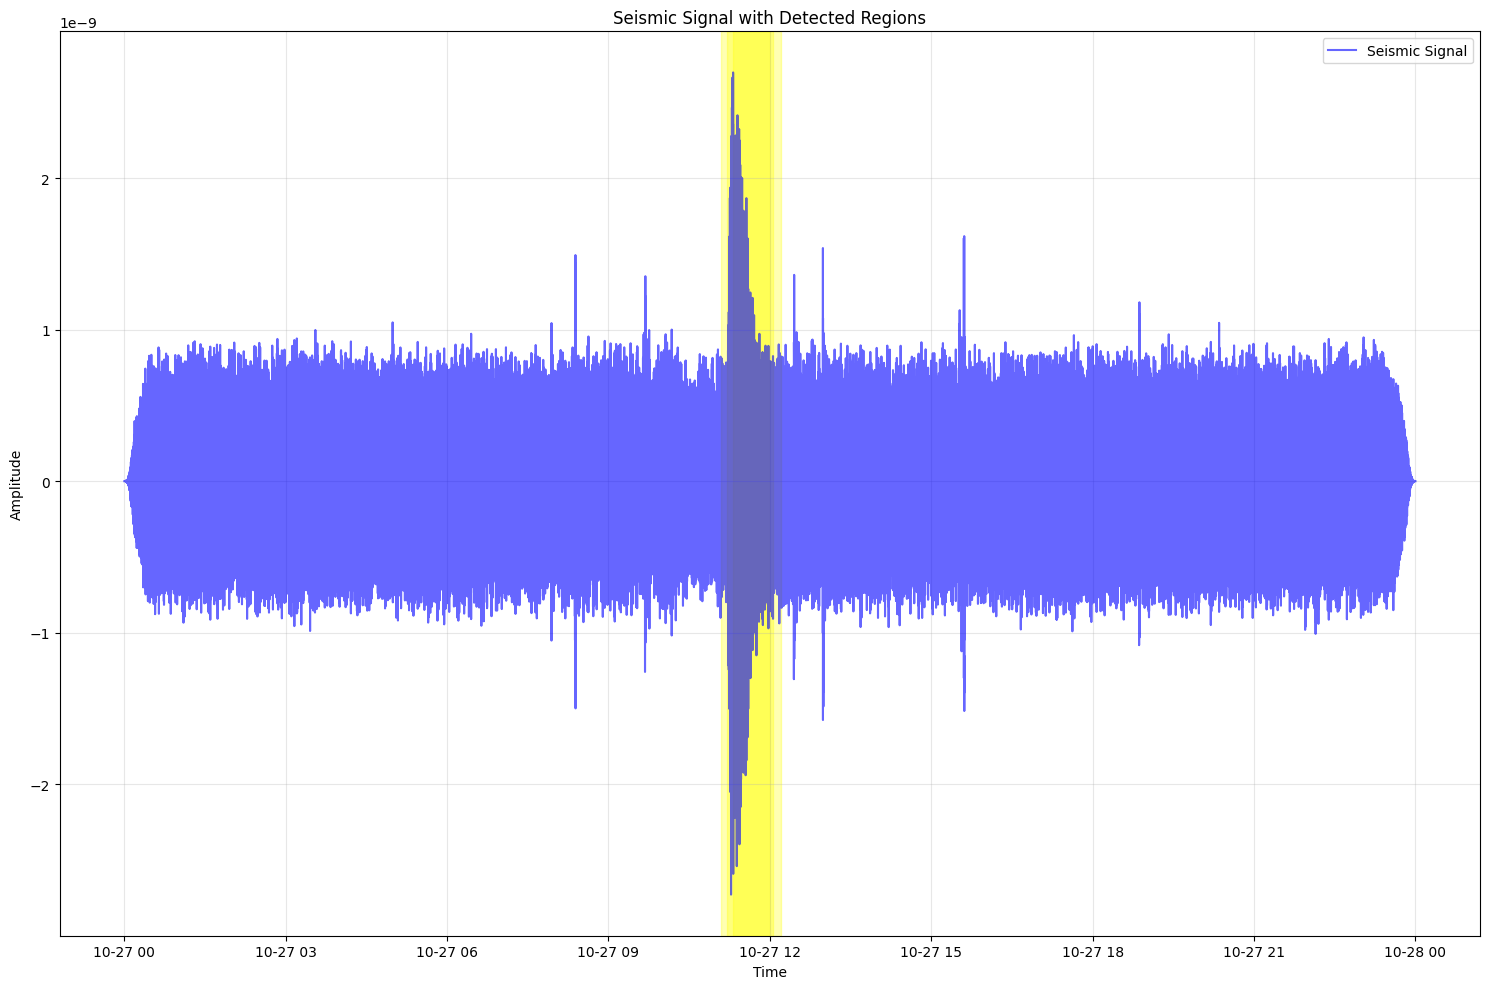

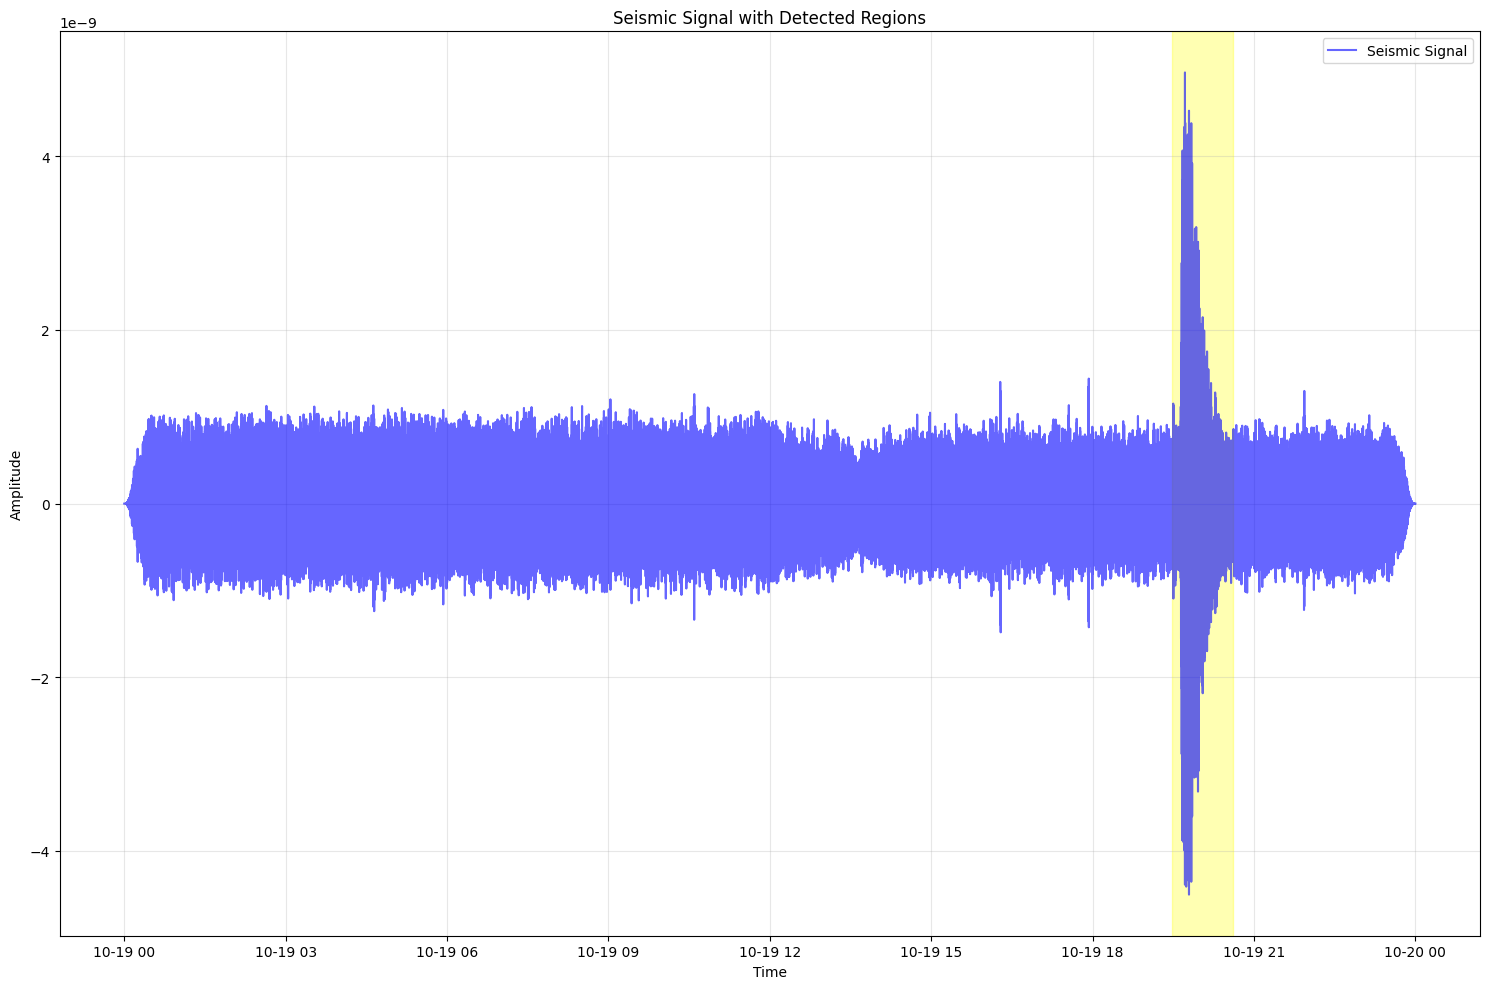

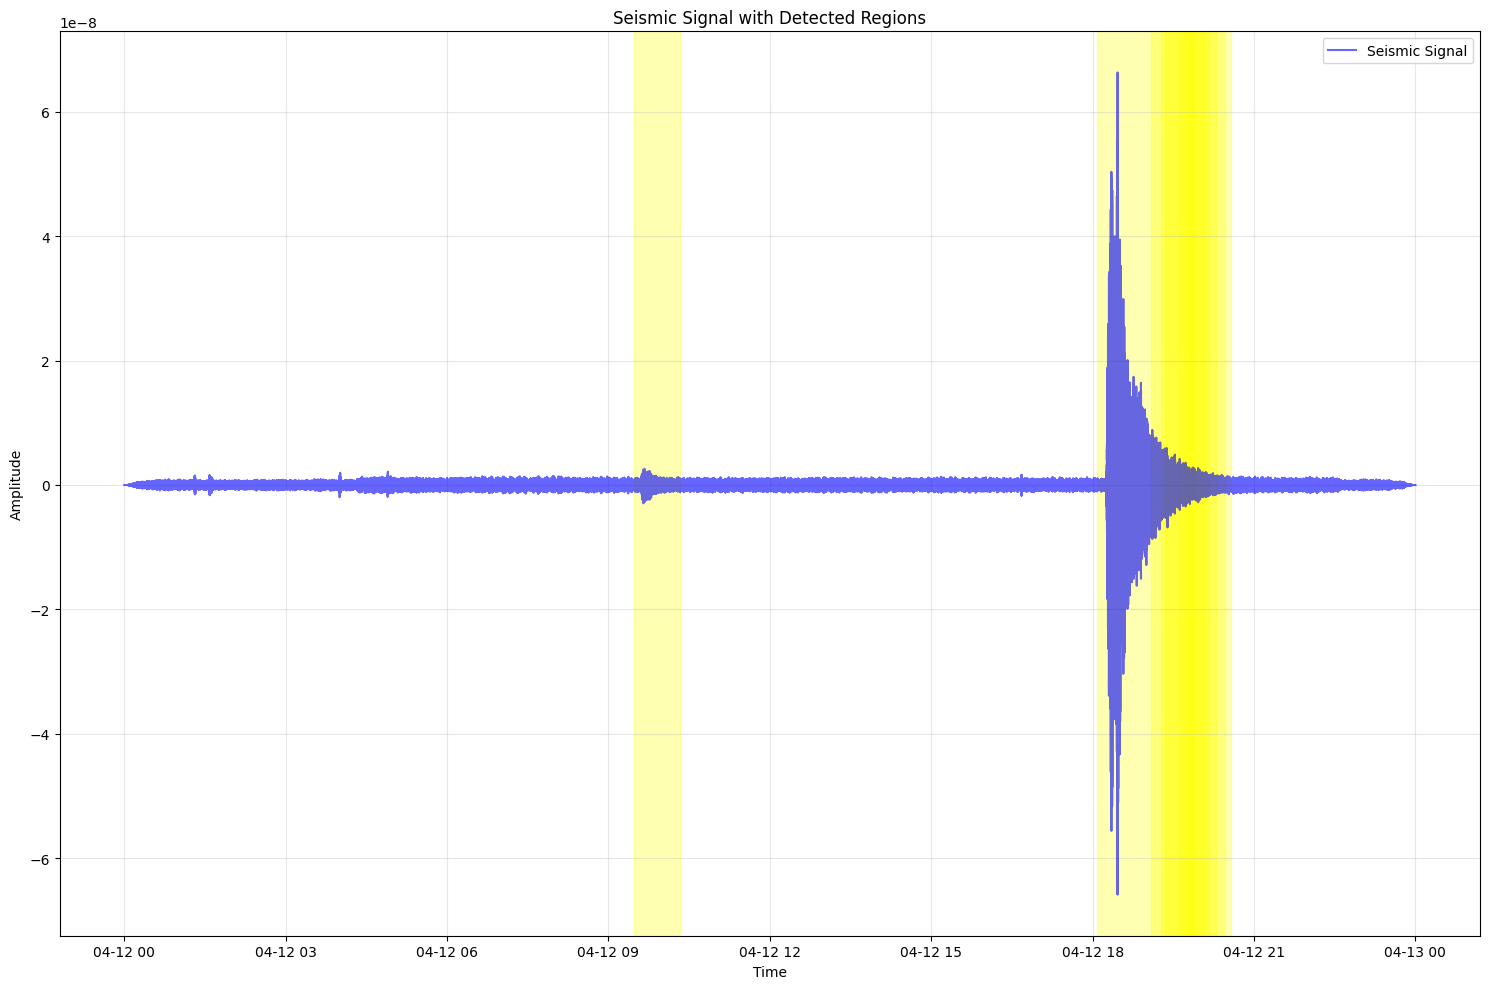

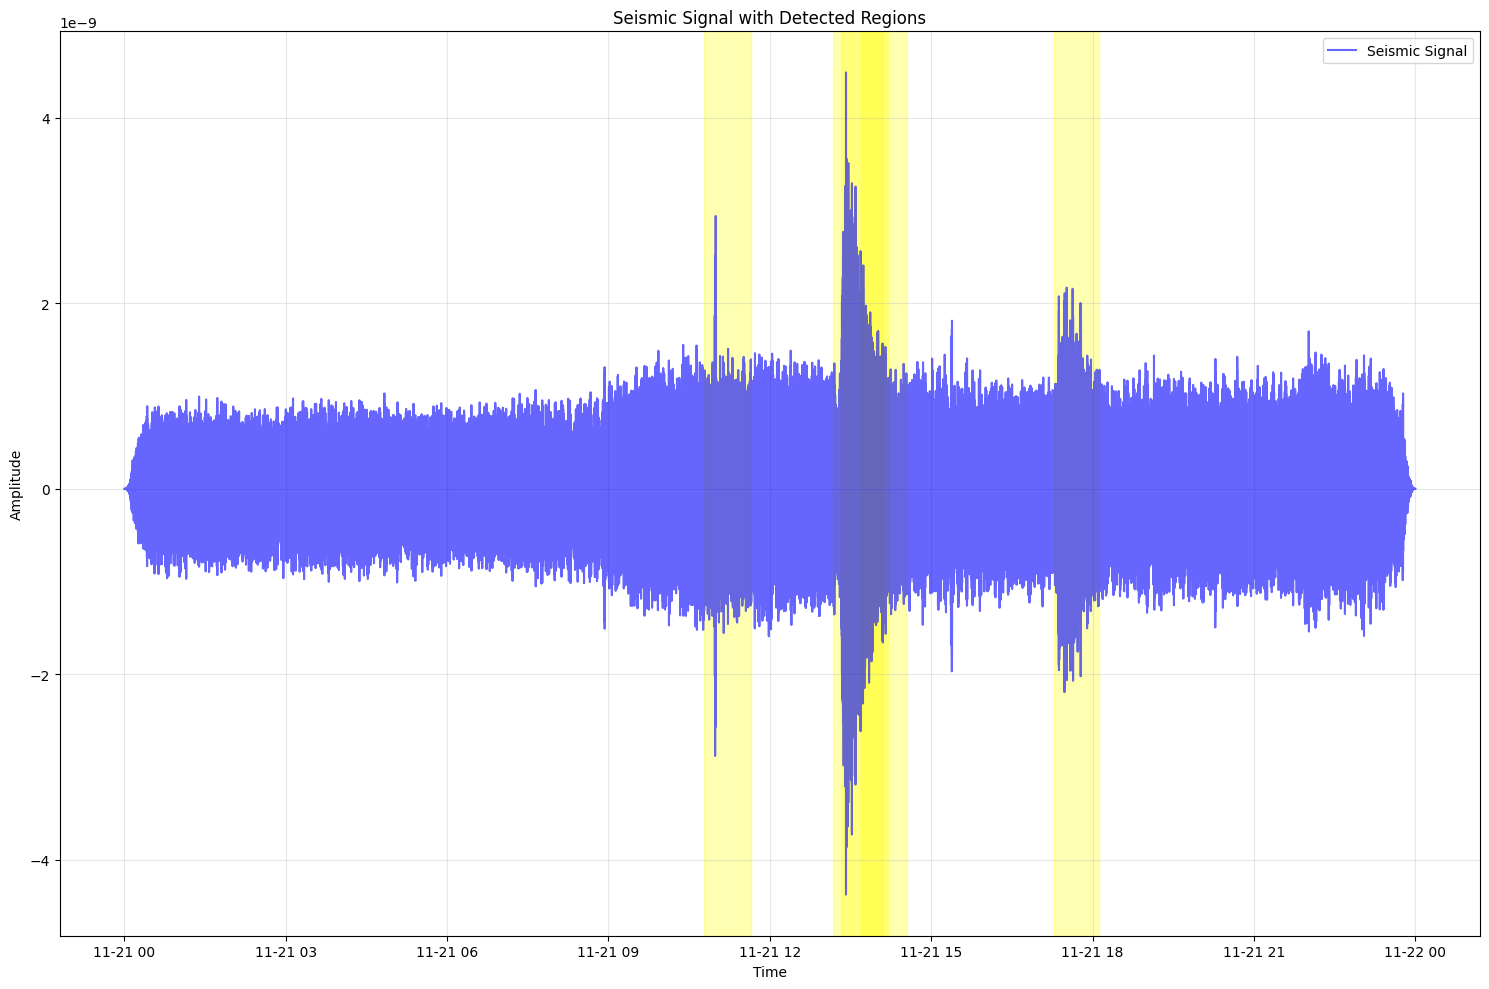

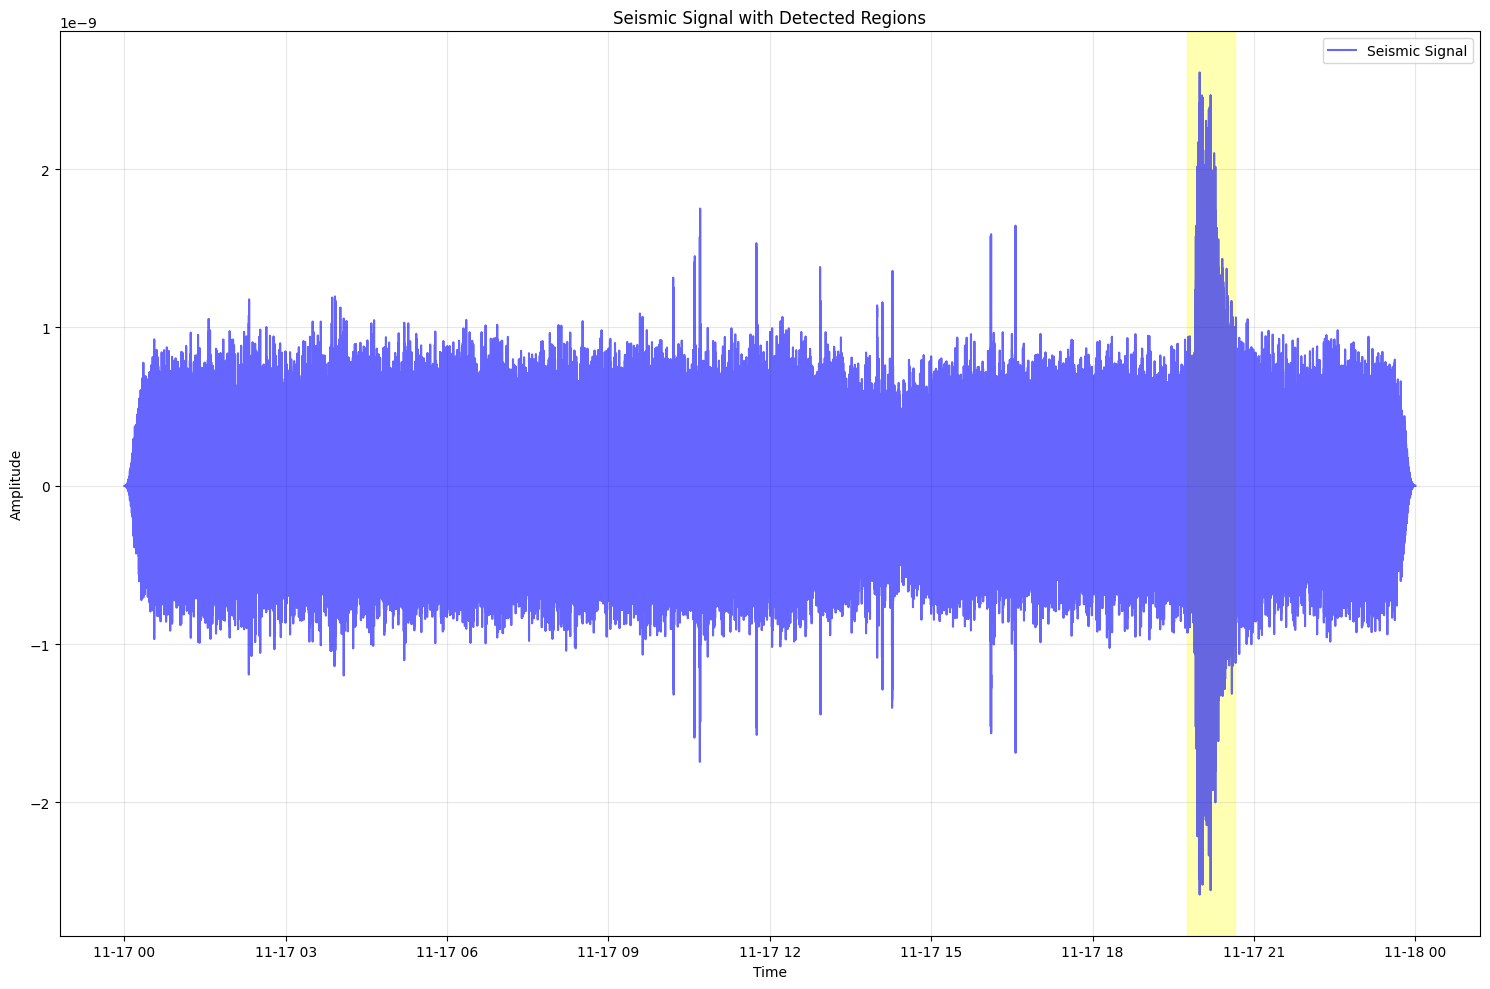

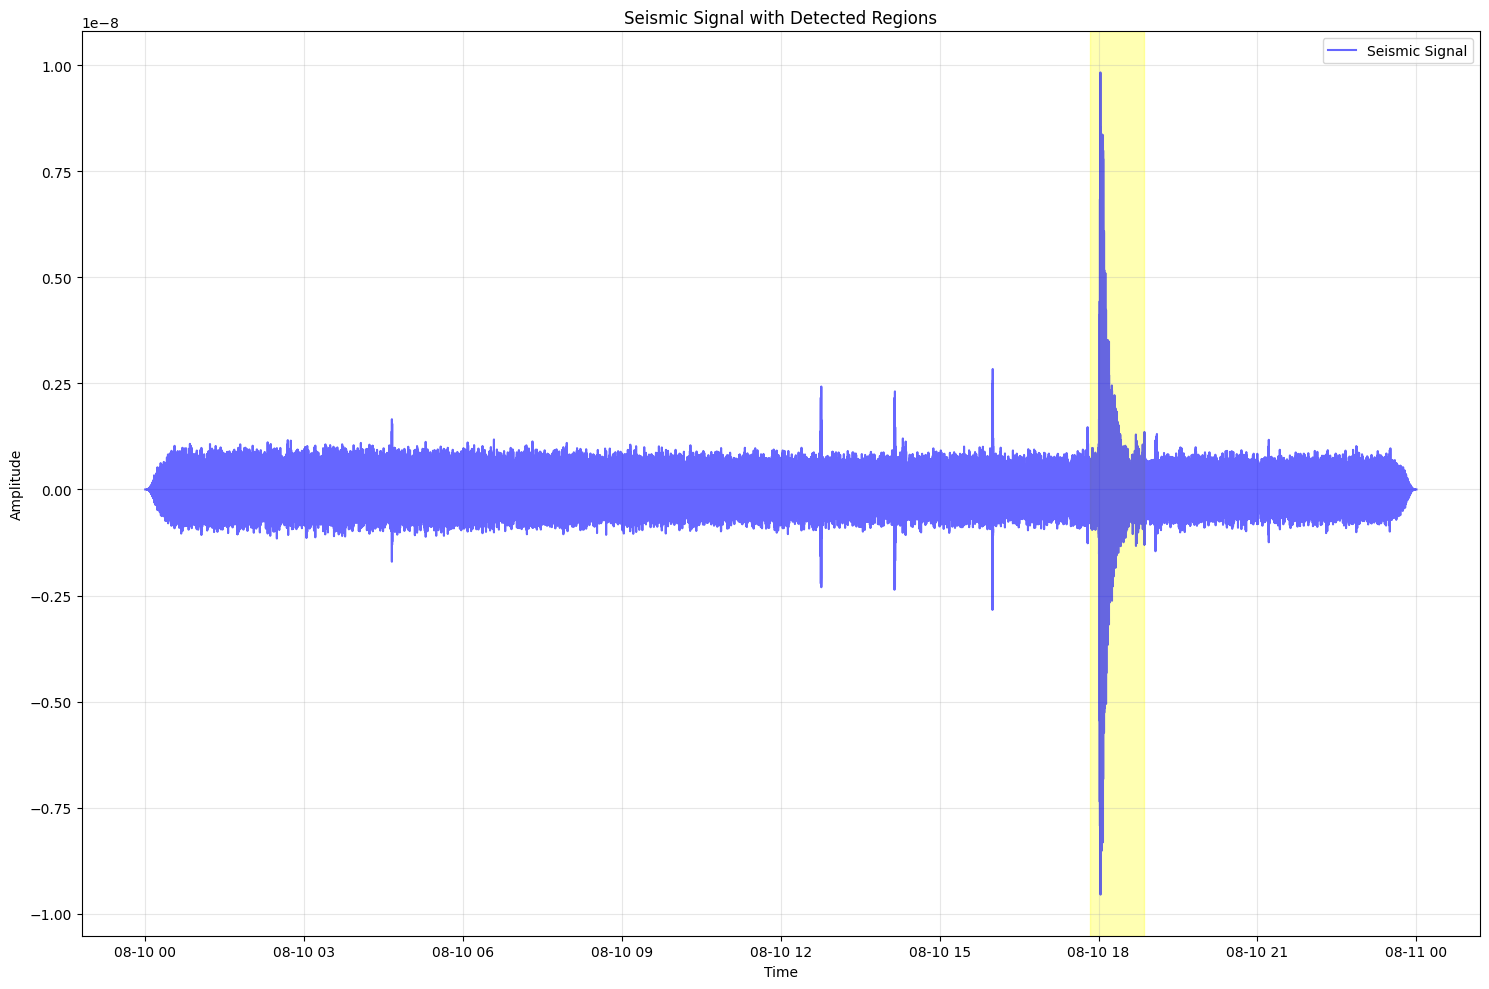

In [87]:
model_path = MODEL_NAME + ".keras"
scaler_path = MODEL_NAME + "_scaler.pkl"

# loop over all csv files in test data,
# preprocess the dataset and run the inference
data_dir = "/content/space_apps_2024_seismic_detection/data/lunar/test/data/S15_GradeA/"
for file in os.listdir(data_dir):
    if file.endswith('.csv'):
        new_data = load_dataset(
            pd.read_csv(data_dir + file)
        )
        detections = run_inference_engine_v2(model_path, scaler_path, new_data)